# Code to load, calculate and plot SCALE-RM Data
---

Choose the date, time and ensemble size. Previously used dates are 29.05.2016 12:00UTC and 01.06.2016 12:00UTC.

#### !!! Careful with ensemble size of 1000 members, a lot of free memory is necessary !!!

Calculated variables:
1. p_cloud: Probability of at least one cloud in a data column over the whole ensemble
2. ex_cloud: Number of cloudy levels in a data column. Interpreted as the vertical extent of one cloud, since the results of an exact calculation are the same but much slower.
3. ctl: Level of the cloud top (0-20)
4. ctp: Cloud Top Pressure level (975hPa-100hPa)
5. cloud status: classification of cloud probability (p_cloud) 
6. cloud top: classification of cloud top pressure (ctp)
7. ex_cloud_high/medi/low: classification of cloud extent (ex_cloud)
8. w: Vertical wind data (means over ensemble, levels and both are used)
9. phase: Cloud water phase (liquid, ice)


In [1]:
%matplotlib inline 

import matplotlib
from matplotlib import pyplot as plt

import sys, os, copy, scipy, math, getpass, subprocess, argparse, time, re, pdb, socket, warnings
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
from enstools.io import read, write

import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import dask

In [2]:
import warnings

## Load Data

In [3]:
# Load cloud and w data 'CL0020', 'CL0040', 'CL0200', 'CL1000'
# Load phase data 'PH0020', 'PH0040', 'PH0200', 'PH1000'
# 29.05.2016 12:00 and 01.06.2016 12:00 available (used forecast is 15:00 UTC)
# Change ens for different ensemble sizes. 20, 40, 200, 1000 Members available

dask.config.set(scheduler='processes')

day = '29'
month = '05'
time = '1200'
ens = '20'

date = month+day

#convert for the plots
if month == '05':
    m = 'Mai'
elif month == '06':
    m = 'Juni'
if time == '1200':
    t = '15:00'


if ens == '20':
    num = '0020'
    ensemble = 'CL0020'
elif ens == '40':
    num = '0040'
    ensemble = 'CL0040'
elif ens == '200':
    num = '0200'
    ensemble = 'CL0200'
elif ens == '1000':
    num = '1000'
    ensemble = 'CL1000'

path_CL = '/scratch/das/tnecker/kwork/run/'+ensemble+'/2016'+month+day+time+'/'+num+'/member*.nc'
path_PH = '/scratch/das/tnecker/kwork/experiments/germany_3km_15h_en_fcst_1000m/2016'+date+'120000/fcsthy/member*.nc'

dataset_CL = read(path_CL, member_by_filename="member(.*?).nc", in_memory=False)
dataset_PH = read(path_PH, member_by_filename="member(.*?).nc", in_memory=False)
warnings.filterwarnings("default")
warnings.filterwarnings("ignore")

/home/swd/manual/enstools/v2021.11/lib/python3.8/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/swd/manual/enstools/v2021.11/lib/python3.8/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/swd/manual/enstools/v2021.11/lib/python3.8/site-packages/xarray/

In [4]:
# Check datasets
dataset_PH , dataset_PH

(<xarray.Dataset>
 Dimensions:  (time: 6, lon: 250, lat: 352, lev: 20, ens: 1000)
 Coordinates:
   * time     (time) datetime64[ns] 2016-05-29T12:00:00 ... 2016-05-29T17:00:00
   * lon      (lon) float64 1.0 2.0 3.0 4.0 5.0 ... 246.0 247.0 248.0 249.0 250.0
   * lat      (lat) float64 1.0 2.0 3.0 4.0 5.0 ... 348.0 349.0 350.0 351.0 352.0
   * lev      (lev) float64 975.0 950.0 925.0 900.0 ... 250.0 200.0 150.0 100.0
   * ens      (ens) int64 1 2 3 4 5 6 7 8 9 ... 993 994 995 996 997 998 999 1000
 Data variables:
     qc       (time, ens, lev, lat, lon) float32 dask.array<chunksize=(6, 1, 20, 352, 250), meta=np.ndarray>
     qr       (time, ens, lev, lat, lon) float32 dask.array<chunksize=(6, 1, 20, 352, 250), meta=np.ndarray>
     qi       (time, ens, lev, lat, lon) float32 dask.array<chunksize=(6, 1, 20, 352, 250), meta=np.ndarray>
     qs       (time, ens, lev, lat, lon) float32 dask.array<chunksize=(6, 1, 20, 352, 250), meta=np.ndarray>
     qg       (time, ens, lev, lat, lon) float

In [29]:
# Load domain coordinates (Cutoff at the edges due to unrealistic results)
lat2d=np.load('/scratch/das/tnecker/kwork/experiments/lat2d_high_resolution.npy')[7:345,12:243]
lon2d=np.load('/scratch/das/tnecker/kwork/experiments/lon2d_high_resolution.npy')[7:345,12:243]

## Cloud Analysis

In [6]:
def cloud_analysis_per_column(array_ens, probability = True):
    """
    Description
        Computes probability of cloud and number of cloud layers in each cloumn
        Cloud: Hy > 10^-6 kg/kg
    ----------
    Parameters
        numpy.array : array_ens (ens, lev, lat, lon) Ensemble of Total Hydrometeors in kg/kg
    ----------
    Returns
        numpy.array : p_cloud (lat, lon) Probability of cloud between 0 and 1
        numpy.array : ex_cloud (lat, lon) Ensemble mean number of cloudy layers per column (cloud extent)
    """
    
    with warnings.catch_warnings(): # avoid warnings due to np.nan
        warnings.simplefilter("ignore")
        # Mask nan entries / missing data
        array_ens_masked = np.ma.masked_array(array_ens, mask=np.isnan(array_ens))

        # Mask non cloudy levels based on threshold 1e-6
        cloudy_data_false = np.ma.masked_less_equal(array_ens_masked, 1e-6)
        cloudy_data_false_mask = np.ma.getmask(cloudy_data_false)

        if probability:
            # Probability of cloud
            number_of_clouds_in_column_per_member = np.sum(~cloudy_data_false_mask,axis=(1))
            p_cloud = np.sum(np.ma.getmask(np.ma.masked_greater(number_of_clouds_in_column_per_member, 0)),axis=0) / float(array_ens.shape[0])
            return p_cloud
        else:
            # Ensemble mean cloudy layers per column
            ex_cloud = np.sum(~cloudy_data_false_mask, axis=(0,1)) / float(array_ens.shape[0])
            return ex_cloud

In [7]:
def get_cloud_status(p_cloud, frac_trsh, cloud_tsh):
    """
    Description
        Computes cloud masks for cloudy, clear and partial cloudy
    ----------
    Parameters
        numpy.array : p_cloud (lat, lon) Probability of cloud
        float : frac_trsh / Threshold for clear
        float : cloud_tsh / Threshold for cloudy
    ----------
    Returns
        numpy.array : cloudy (lat, lon) bool / True/1=cloudy
        numpy.array : clear (lat, lon) bool / True/1=clear
        numpy.array : partial (lat, lon) bool / True/1=partial
    """
    
    with warnings.catch_warnings(): # avoid warnings due to np.nan
        warnings.simplefilter("ignore")

        # Check if no clear / create suitable mask
        clear = np.ma.getmask(np.ma.masked_less_equal(p_cloud, frac_trsh))
        if clear.shape == (): clear = ~np.ma.getmask(np.ma.masked_less_equal(p_cloud, 2))

        # Check if no cloudy / create suitable mask
        cloudy = np.ma.getmask(np.ma.masked_greater_equal(p_cloud, cloud_tsh))
        if cloudy.shape == (): cloudy = ~np.ma.getmask(np.ma.masked_less_equal(p_cloud, 2))

        masked_1_False = np.ma.getmask(np.ma.masked_less(p_cloud, cloud_tsh))
        masked_0_False = np.ma.getmask(np.ma.masked_greater(p_cloud, frac_trsh))
        partial = ~(~masked_1_False + ~masked_0_False)
        return cloudy, partial, clear 

In [8]:
def get_cloud_top_level(array_ens):
    """
    Description
        Find Cloud Top Level (CTL) / array_ens (ens, lev, lat, lon)
        Note: Works for pcloud->cloud status based on frac_trsh = 0. and cloud_tsh = 1.
    ----------
    Parameters
        numpy.array : array_ens (ens, lev, lat, lon) Ensemble of Total Hydrometeors in kg/kg
    ----------
    Returns
        numpy.array : cloud_index / ctl mean, max, min, std (lat, lon) (0,20)
    """

    with warnings.catch_warnings(): # avoid warnings due to np.nan
        warnings.simplefilter("ignore")

        # Mask nan entries / missing data
        array_ens_masked = np.ma.masked_array(array_ens, mask=np.isnan(array_ens))

        # Mask non cloudy levels based on hy threshold 1e-6 kg/kg
        # Threshold as in Kerr et al 2015 / Zhang et al 2021 = 10⁻6 kg/kg
        cloudy_data_false = np.ma.masked_less_equal(array_ens_masked, 1e-6)
        cloudy_data_false_mask = np.ma.getmask(cloudy_data_false)
        cloudy_data_true_mask = ~cloudy_data_false_mask
        # cloudmask (cloud=true/1)

        # Create index array with increasing indices from 0=sfc to 1=TOA with same dimensions as ensemble array
        array_ens_ones = np.ones_like(cloudy_data_true_mask, dtype=np.int)
        array_ens_cloud = np.copy(cloudy_data_true_mask).astype(int)
        array_ens_index = np.cumsum(array_ens_ones, axis=1) - 1
        array_ens_argmax_ = array_ens_cloud * array_ens_index

        # Fill index array with np.nan where cloudfree
        array_ens_argmax = np.where(cloudy_data_false_mask, np.nan, array_ens_argmax_)

        # Compute ensemble max of CTL
        # find max index of ctl in column along ensemble dimension
        array_argmax = np.nanmax(array_ens_argmax, axis=1)
        ctl_max_ = np.nanmax(array_argmax, axis=0)

        # Compute ensemble min of CTL
        ctl_argmin = np.where(array_argmax == 0 , 20, array_argmax)
        ctl_min_ = np.nanmin(ctl_argmin, axis=0)

        # Compute ensemble mean of CTL
        ctl_argmean = np.where(array_argmax == 0 , np.nan, array_argmax)
        ctl_mean_ = np.nanmean(ctl_argmean, axis=0)

        # Compute ensemble std of CTL
        ctl_std_ = np.nanstd(ctl_argmean, axis=0)

        # Mask column where all member are cloudfree with np.nan
        ctl_mean = np.where(ctl_mean_ == np.nan, np.nan,  np.round(ctl_mean_,0))
        ctl_max = np.where(ctl_min_ == 20, np.nan,  ctl_max_)
        ctl_min = np.where(ctl_min_ == 20, np.nan,  ctl_min_)
        ctl_std = np.where(ctl_min_ == 20, np.nan,  ctl_std_)

        return ctl_mean, ctl_max, ctl_min, ctl_std

In [9]:
def ctl_to_ctp(ctl):
    """
    Description
        Converts Cloud Top Level to Cloud Top Pressure (CTP) / array_ens (ens, lev, lat, lon)
    ----------
    Parameters
        numpy.array : cloud_index / ctl (lat, lon) (0,19)
    ----------
    Returns
        numpy.array : Cloud Top Pressure (ctp) (lat, lon) (975, ..., 100 hPa)
    """
    
    with warnings.catch_warnings(): # avoid warnings due to np.nan
        warnings.simplefilter("ignore")

        p_level = np.array([975., 950., 925., 900., 850., 800., 750., 700., 650., 600., 550.,
           500., 450., 400., 350., 300., 250., 200., 150., 100.])

        ctp = np.zeros(ctl.shape)
        for ii in range(ctl.shape[0]):
            for jj in range(ctl.shape[1]):
                if np.isnan(ctl[ii,jj]):
                    ctp[ii,jj] = np.nan
                else:
                    ctp[ii,jj] = p_level[np.int(ctl[ii,jj])]
        return ctp

In [10]:
def group_cloud_top_heights(ctp_mean):
    """
    Description
        Group clouds in high / medium / low based on cloud top mean level (ctp_max) 
    ----------
    Parameters
        numpy.array : ctp_mean (ens, lev, lat, lon) Mean cloud top pressure in ensemble
    ----------
    Returns
        numpy.array : clow (lat, lon) bool / True/1=low
                      cmedi (lat, lon) bool / True/1=medium
                      chigh (lat, lon) bool / True/1=high

    """
    
    with warnings.catch_warnings(): # avoid warnings due to np.nan
        warnings.simplefilter("ignore")

        # Groupd clouds based on ctp_max
        chigh = np.where(ctp_max <= 300, True, False)
        clow = np.where(ctp_max >= 700, True, False)
        ctmp = clow + chigh + np.where(np.isnan(ctp_max), True, False)
        cmedi = ~ctmp

        return clow, cmedi, chigh

## Variables

In [11]:
# Load Variables as np.arrays. This cell uses a lot of memory with 1000 members!!!
p_cloud = cloud_analysis_per_column(dataset_CL['qhydro'].isel(lat = np.arange(7,345,1),lon = np.arange(12,243,1),time=1), probability = True)
ex_cloud = cloud_analysis_per_column(dataset_CL['qhydro'].isel(lat = np.arange(7,345,1),lon = np.arange(12,243,1),time=1), probability = False)


ctl = get_cloud_top_level(dataset_CL['qhydro'].isel(lat = np.arange(7,345,1),lon = np.arange(12,243,1),time=1))
ctl_mean = ctl[0]
ctl_max = ctl[1]
ctl_min = ctl[2]
ctl_std = ctl[3]


cloud_status = get_cloud_status(p_cloud, frac_trsh = 0.05, cloud_tsh = 0.95 )
cloudy_bool = cloud_status[0]
partial_bool = cloud_status[1]
clear_bool = cloud_status[2]

cloudy = np.where(cloudy_bool,3,0)
partial = np.where(partial_bool,2,0)
clear = np.where(clear_bool,1,0)


ctp_mean = ctl_to_ctp(ctl_mean)
ctp_max = ctl_to_ctp(ctl_max)
ctp_min = ctl_to_ctp(ctl_min)
ctp_std = ctl_to_ctp(ctl_std)


cloud_top = group_cloud_top_heights(ctp_mean)
ct_low_bool = cloud_top[0]
ct_medi_bool = cloud_top[1]
ct_high_bool = cloud_top[2]

ct_nan = np.where(np.isnan(ctp_mean),np.nan,0)
ct_low = np.where(ct_low_bool,1,0)
ct_medi = np.where(ct_medi_bool,2,0)
ct_high = np.where(ct_high_bool,3,0)

ex_cloud_high = np.where(ex_cloud>=10,3,0)
ex_cloud_medi = np.where((ex_cloud<10) & (ex_cloud>2),2,0)
ex_cloud_low = np.where(ex_cloud<=2,1,0)

## Plotting Cloud Variables

### Cloud Top Pressure

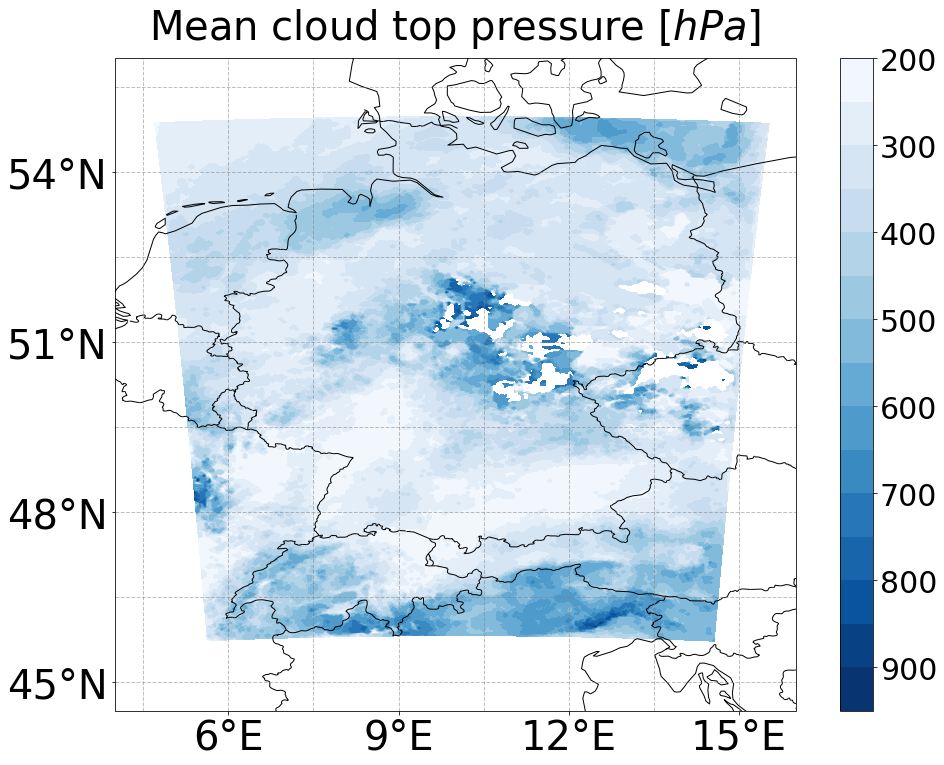

In [13]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# Plot precipitaion with special colorbar
clevs = np.flip(dataset_CL.coords['lev'].values[2:18])
#colors = ("#ffffff","#F0EABB","#C0E69F","#72E1A2","#00D8BC","#00C7DC","#00AAF2","#847CF2","#BA3CD0","#B40087")
plt.contourf(lon2d, lat2d,ctp_mean,clevs,cmap='Blues', transform=crs.PlateCarree()) 
# plt.colorbar(extend='both')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)
cb.ax.invert_yaxis()

# Customize fig, axis and labels
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
ax.set_title('Mean cloud top pressure [$hPa$]', size =40,y=1.02)
# ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_ctp_mean_'+ens+'mem_2016'+date+'1500.png')

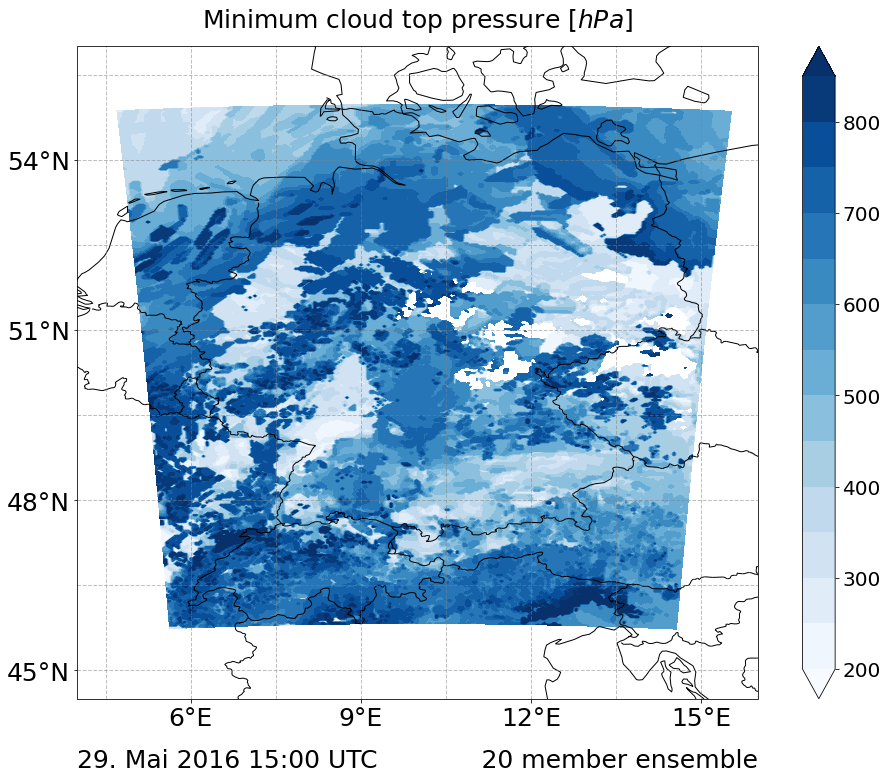

In [17]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# Plot precipitaion with special colorbar
clevs = np.flip(dataset_CL.coords['lev'].values[4:18])
#colors = ("#ffffff","#F0EABB","#C0E69F","#72E1A2","#00D8BC","#00C7DC","#00AAF2","#847CF2","#BA3CD0","#B40087")
plt.contourf(lon2d, lat2d,ctp_min,clevs,cmap='Blues', extend='both', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

# Customize fig, axis and labels
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.set_title('Minimum cloud top pressure [$hPa$]', size =25,y=1.02)
ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/ctp_min_'+ens+'mem_2016'+date+'1500.png')

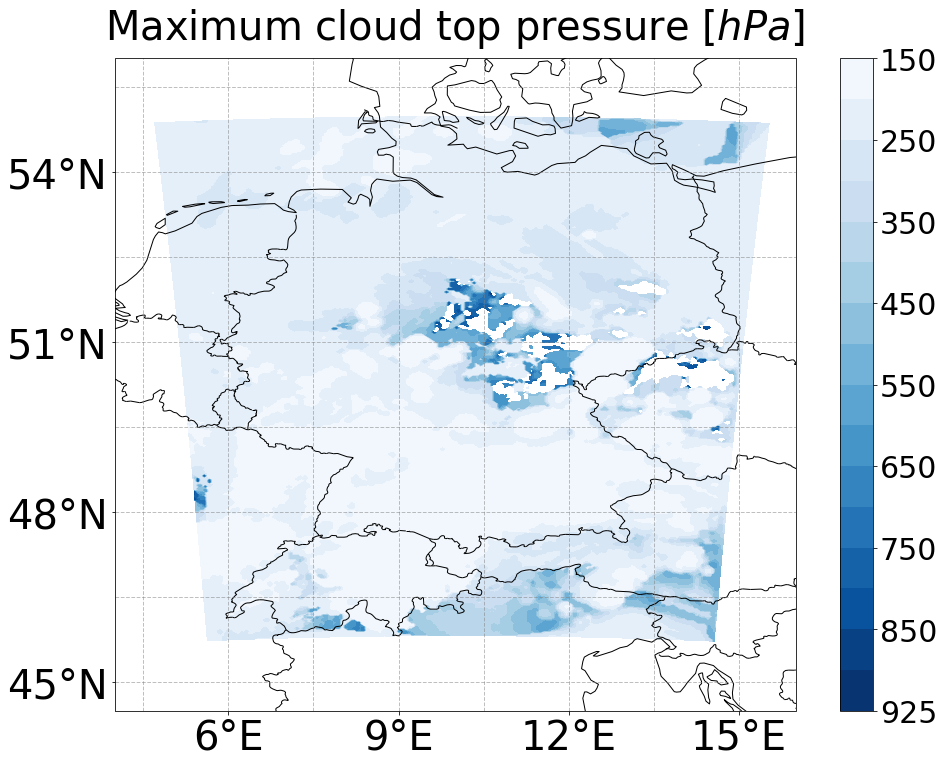

In [15]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# Plot precipitaion with special colorbar
clevs = np.flip(dataset_CL.coords['lev'].values[2:19])
#colors = ("#ffffff","#F0EABB","#C0E69F","#72E1A2","#00D8BC","#00C7DC","#00AAF2","#847CF2","#BA3CD0","#B40087")
plt.contourf(lon2d, lat2d,ctp_max,clevs,cmap='Blues', extend='neither', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)
cb.ax.invert_yaxis()

# Customize fig, axis and labels
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
ax.set_title('Maximum cloud top pressure [$hPa$]', size =40,y=1.02)
# ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_ctp_max_'+ens+'mem_2016'+date+'1500.png')

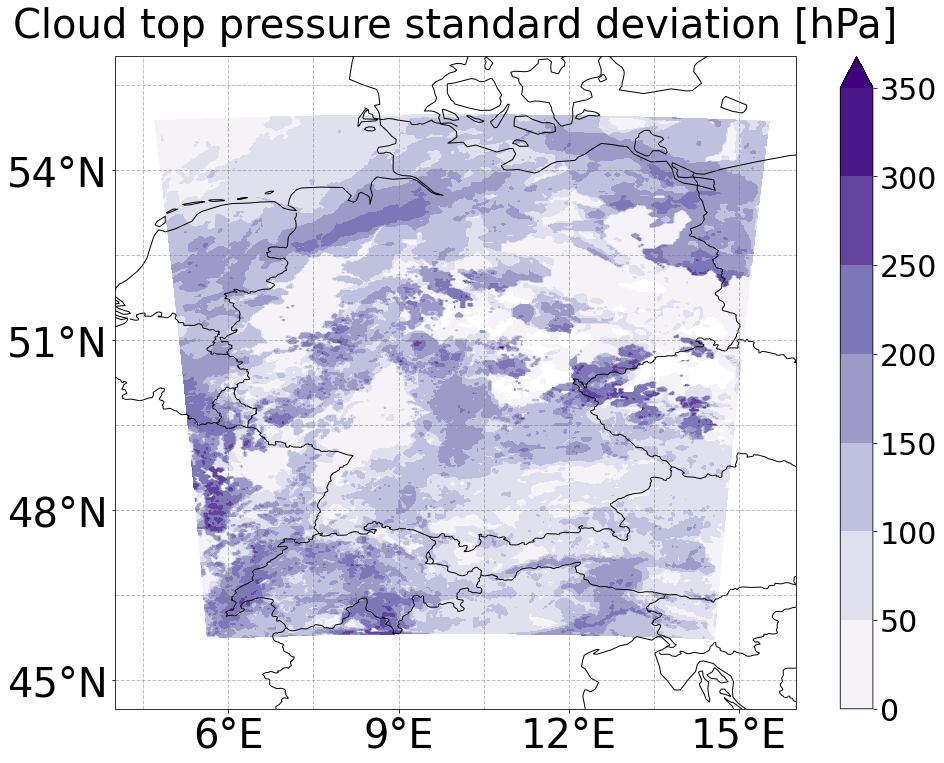

In [18]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# Plot precipitaion with special colorbar
clevs = np.arange(0,8,1)*50
#colors = ("#ffffff","#F0EABB","#C0E69F","#72E1A2","#00D8BC","#00C7DC","#00AAF2","#847CF2","#BA3CD0","#B40087")
plt.contourf(lon2d, lat2d, ctl_std*50,clevs,cmap='Purples', extend='max', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)

# Customize fig, axis and labels
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
ax.set_title('Cloud top pressure standard deviation [hPa]', size =40,y=1.02)
# ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_ctp_std_'+ens+'mem_2016'+date+'1500.png')

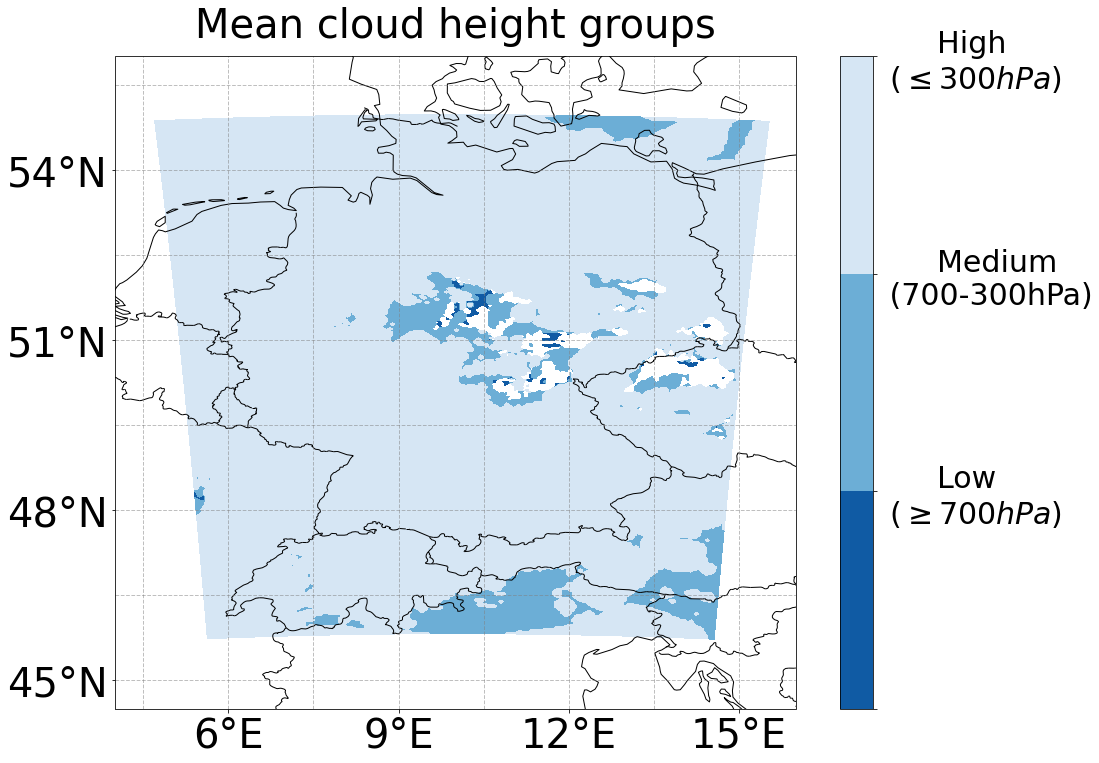

In [26]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

clevs = [0,1,2,3]
# colors = ("#ffffff",'#0000FF')
plt.contourf(lon2d, lat2d,ct_low+ct_medi+ct_high+ct_nan,clevs,cmap = 'Blues_r', extend='neither', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)
cb.ax.set_yticklabels(['','      Low \n ($\geq 700hPa$)', '      Medium \n (700-300hPa)', '      High \n ($\leq 300hPa$)'])

# Customize fig, axis and labels
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
ax.set_title('Mean cloud height groups', size =40,y=1.02)
# ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_cloud_height_group_'+ens+'mem_2016'+date+'1500.png')

### Cloud top level

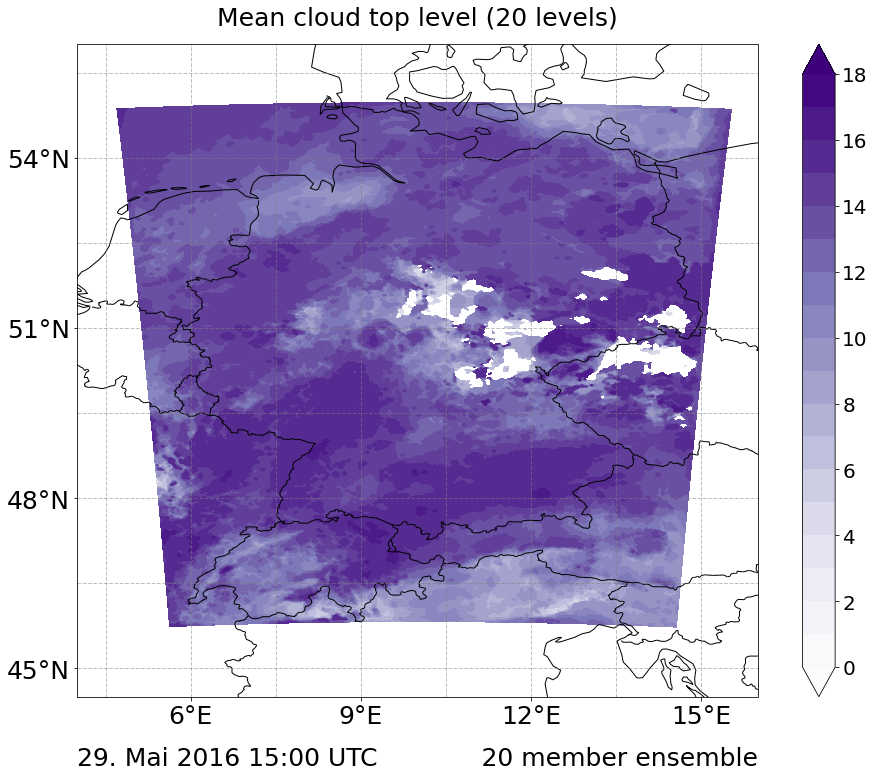

In [19]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# Plot precipitaion with special colorbar
clevs = np.arange(0,19,1)
#colors = ("#ffffff","#F0EABB","#C0E69F","#72E1A2","#00D8BC","#00C7DC","#00AAF2","#847CF2","#BA3CD0","#B40087")
plt.contourf(lon2d, lat2d, ctl_mean,clevs,cmap='Purples', extend='both', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

# Customize fig, axis and labels
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.set_title('Mean cloud top level (20 levels)', size =25,y=1.02)
ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/ctl_mean_'+ens+'mem_2016'+date+'1500.png')

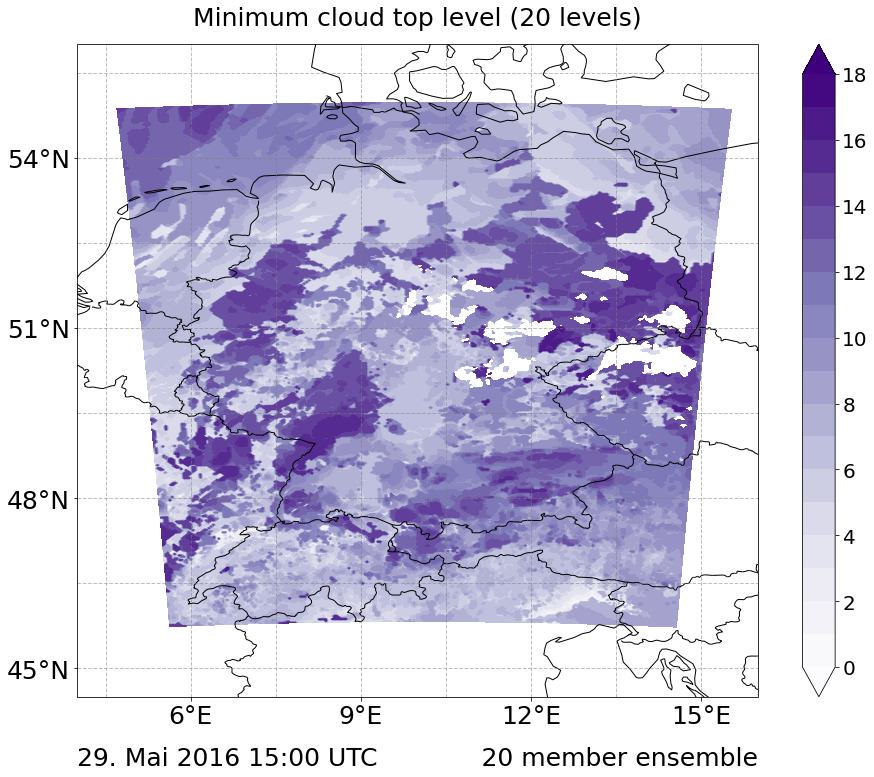

In [20]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# Plot precipitaion with special colorbar
clevs = np.arange(0,19,1)
#colors = ("#ffffff","#F0EABB","#C0E69F","#72E1A2","#00D8BC","#00C7DC","#00AAF2","#847CF2","#BA3CD0","#B40087")
plt.contourf(lon2d, lat2d, ctl_min,clevs,cmap='Purples', extend='both', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

# Customize fig, axis and labels
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.set_title('Minimum cloud top level (20 levels)', size =25,y=1.02)
ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/ctl_min_'+ens+'mem_2016'+date+'1500.png')

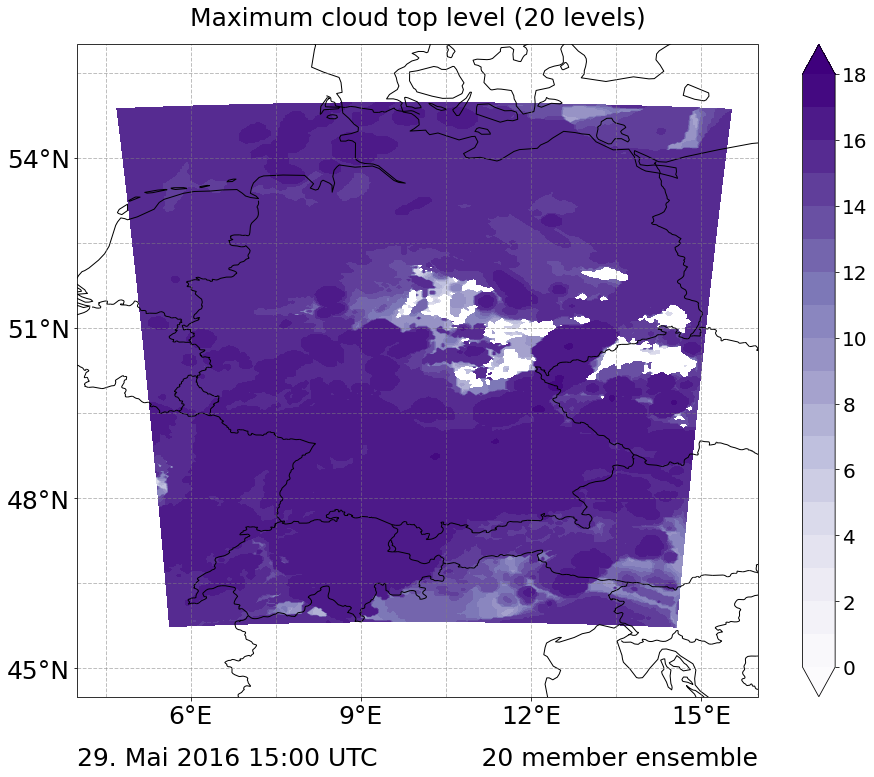

In [21]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# Plot precipitaion with special colorbar
clevs = np.arange(0,19,1)
#colors = ("#ffffff","#F0EABB","#C0E69F","#72E1A2","#00D8BC","#00C7DC","#00AAF2","#847CF2","#BA3CD0","#B40087")
plt.contourf(lon2d, lat2d, ctl_max,clevs,cmap='Purples', extend='both', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

# Customize fig, axis and labels
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.set_title('Maximum cloud top level (20 levels)', size =25,y=1.02)
ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/ctl_max_'+ens+'mem_2016'+date+'1500.png')

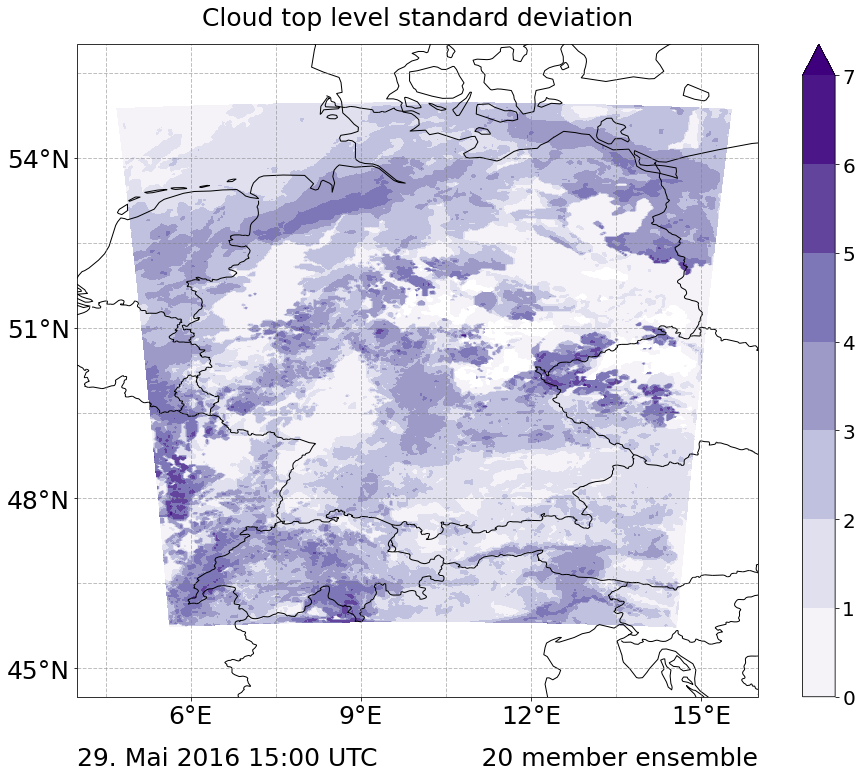

In [22]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# Plot precipitaion with special colorbar
clevs = np.arange(0,8,1)
#colors = ("#ffffff","#F0EABB","#C0E69F","#72E1A2","#00D8BC","#00C7DC","#00AAF2","#847CF2","#BA3CD0","#B40087")
plt.contourf(lon2d, lat2d, ctl_std,clevs,cmap='Purples', extend='max', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

# Customize fig, axis and labels
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.set_title('Cloud top level standard deviation', size =25,y=1.02)
ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/ctl_std_'+ens+'mem_2016'+date+'1500.png')

### Cloud Probability

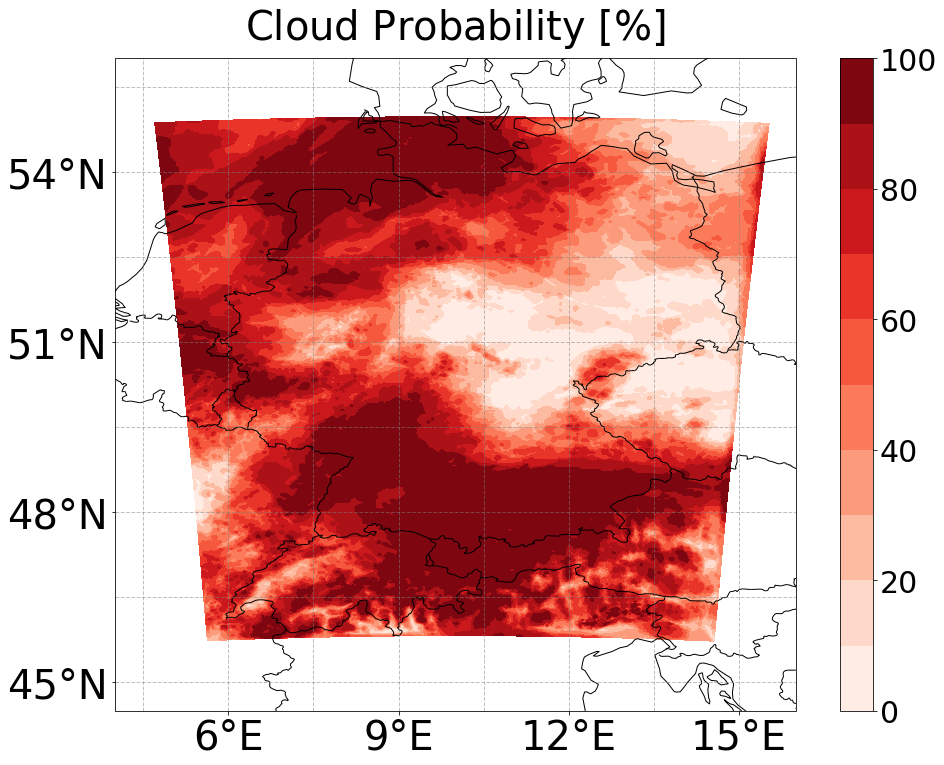

In [23]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# Plot precipitaion with special colorbar
clevs = np.linspace(0,100,11)
#colors = ("#ffffff","#F0EABB","#C0E69F","#72E1A2","#00D8BC","#00C7DC","#00AAF2","#847CF2","#BA3CD0","#B40087")
plt.contourf(lon2d, lat2d,p_cloud*100,clevs,cmap='Reds', extend='neither', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)

# Customize fig, axis and labels
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
ax.set_title('Cloud Probability [$\%$]', size =40,y=1.02)
# ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_cloud_p_'+ens+'mem_2016'+date+'1500.png')

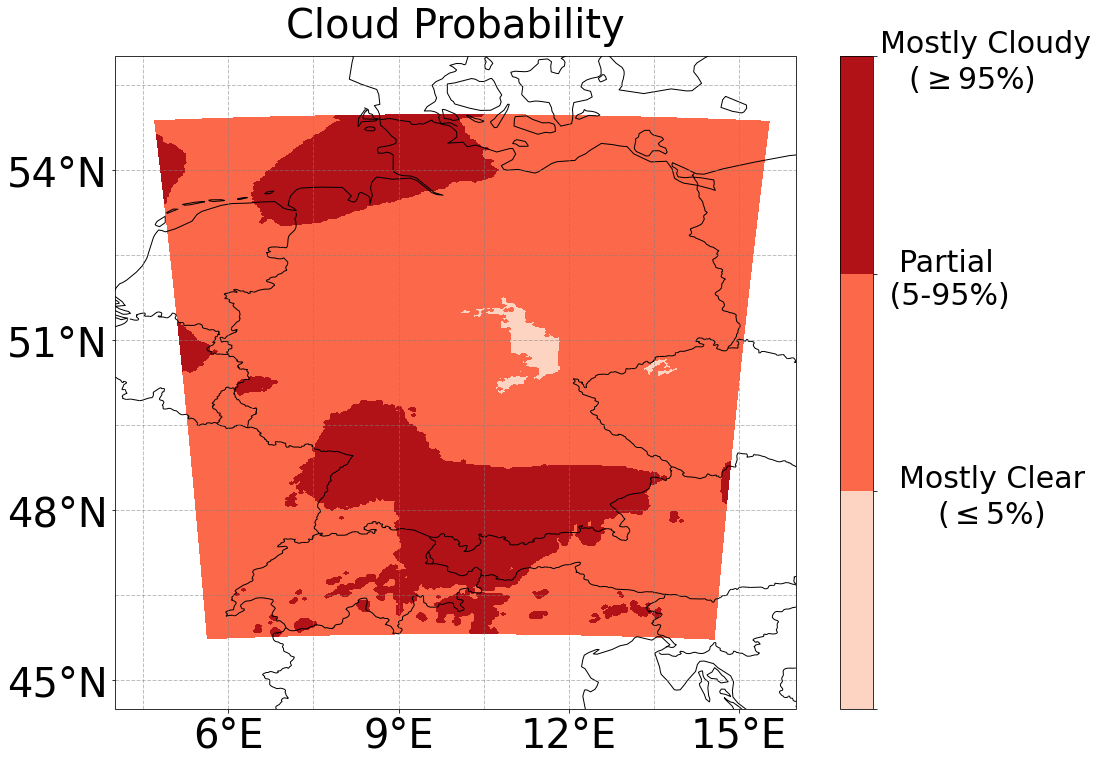

In [29]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

clevs = [0,1,2,3]
# colors = ("#ffffff",'#0000FF')
plt.contourf(lon2d, lat2d,cloudy+partial+clear,clevs,cmap = 'Reds', extend='neither', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)
cb.ax.set_yticklabels(['','  Mostly Clear \n      ($\leq 5\%$)', '  Partial \n (5-95%)', 'Mostly Cloudy \n   ($\geq 95\%$)'])

# Customize fig, axis and labels
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
ax.set_title('Cloud Probability', size =40,y=1.02)
# ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_cloud_status'+ens+'mem_2016'+date+'1500.png')

### Cloud Extent

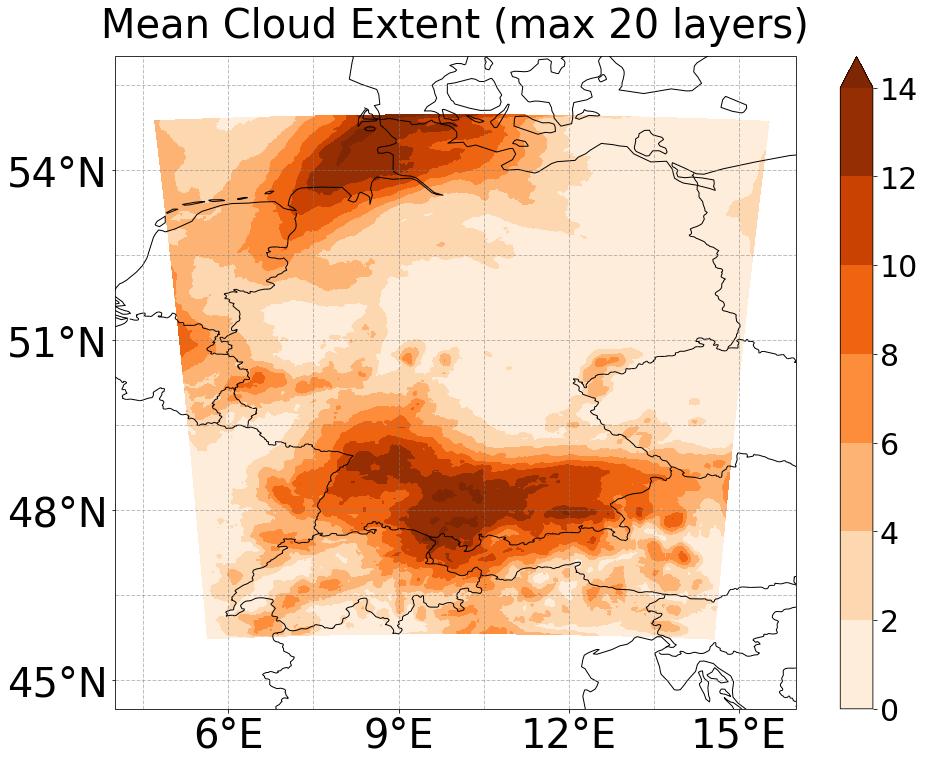

In [24]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# Plot precipitaion with special colorbar
clevs = np.linspace(0,14,8)
#colors = ("#ffffff","#F0EABB","#C0E69F","#72E1A2","#00D8BC","#00C7DC","#00AAF2","#847CF2","#BA3CD0","#B40087")
plt.contourf(lon2d, lat2d,ex_cloud,clevs,cmap='Oranges', extend='max', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)

# Customize fig, axis and labels
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
ax.set_title('Mean Cloud Extent (max 20 layers)', size =40,y=1.02)
# ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_l_cloud_'+ens+'mem_2016'+date+'1500.png')

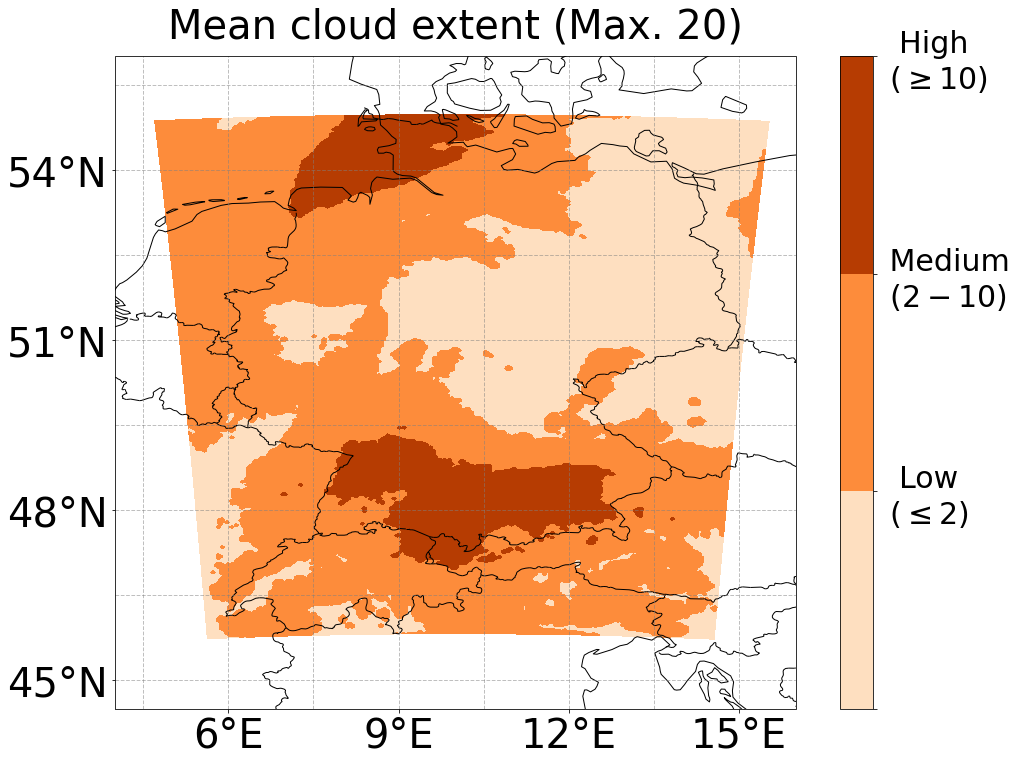

In [25]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

clevs = [0,1,2,3]
# colors = ("#ffffff",'#0000FF')
plt.contourf(lon2d, lat2d,ex_cloud_low+ex_cloud_medi+ex_cloud_high,clevs,cmap = 'Oranges', extend='neither', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)
cb.ax.set_yticklabels(['','  Low \n ($\leq 2$)', ' Medium \n ($2-10$)', '  High \n ($\geq 10$)'])

# Customize fig, axis and labels
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
ax.set_title('Mean cloud extent (Max. 20)', size =40,y=1.02)
# ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_cloud_extent_'+ens+'mem_2016'+date+'1500.png')

## Plotting Vertical Wind

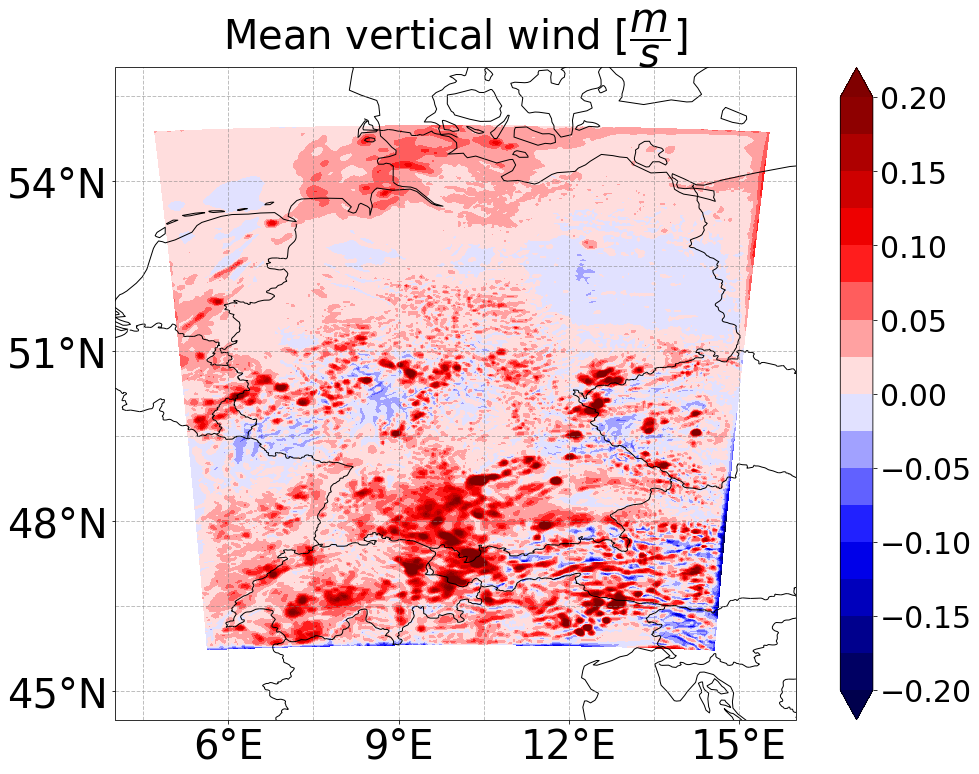

In [27]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# Plot precipitaion with special colorbar
clevs = np.linspace(-0.2,0.2,17)
#colors = ("#ffffff","#F0EABB","#C0E69F","#72E1A2","#00D8BC","#00C7DC","#00AAF2","#847CF2","#BA3CD0","#B40087")
plt.contourf(lon2d, lat2d,dataset_CL.isel(time=1, lat = np.arange(7,345,1),lon = np.arange(12,243,1)).mean('ens').mean('lev')['w'],clevs,cmap='seismic', extend='both', transform=crs.PlateCarree()) 
cb = plt.colorbar()
# cb.ax.set_yticklabels(np.linspace(-0.2,0.2,21))
cb.ax.tick_params(labelsize=30)

# Customize fig, axis and labels
ax.set_title('Mean vertical wind $[\dfrac{m}{s}]$', size =40,y=1.02)
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
# ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_mean_w_'+'_'+ens+'mem_2016'+date+'1500.png')

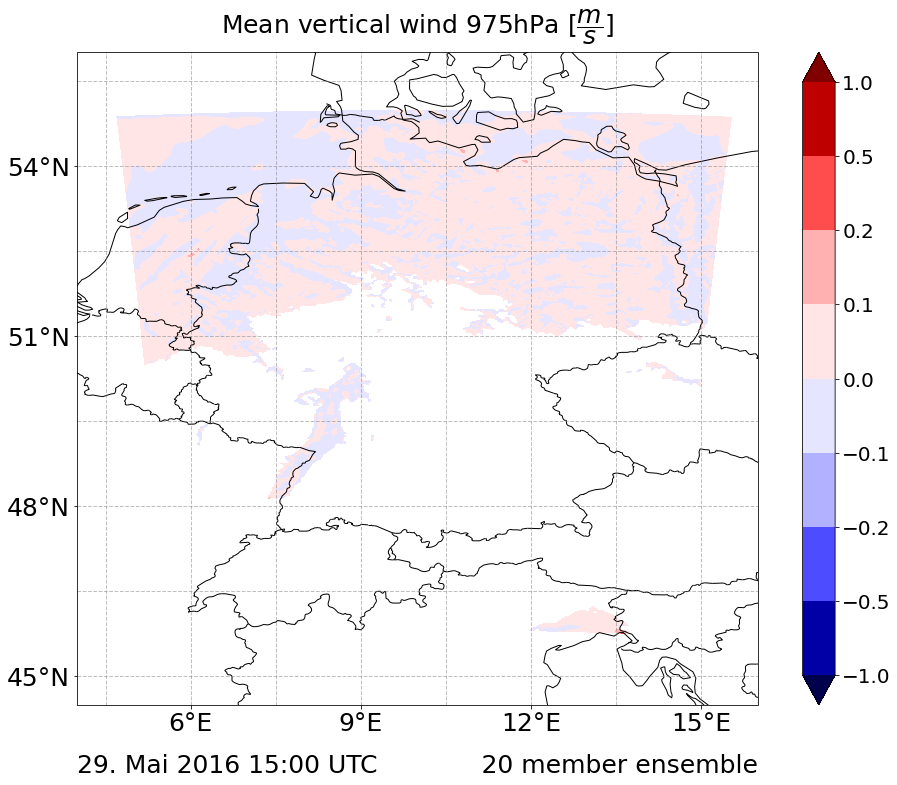

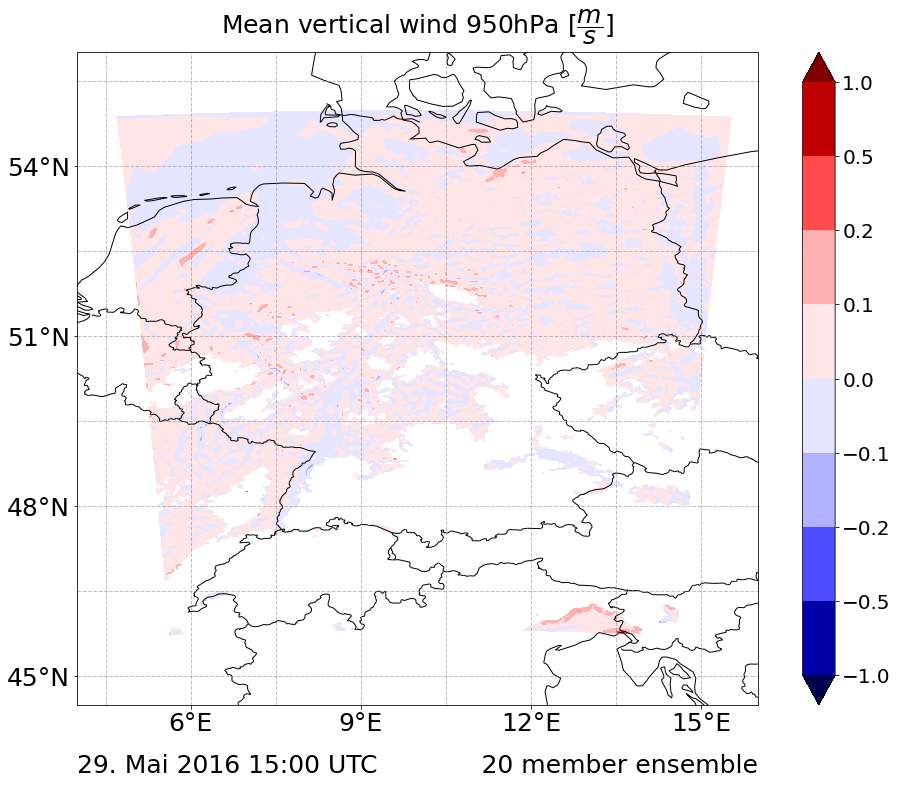

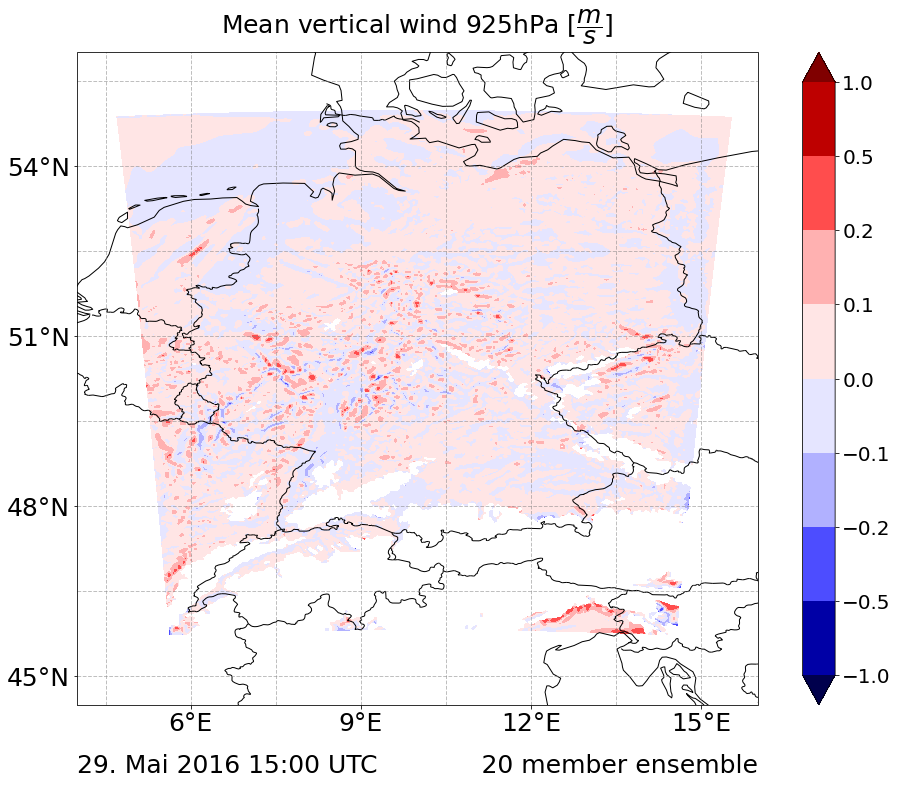

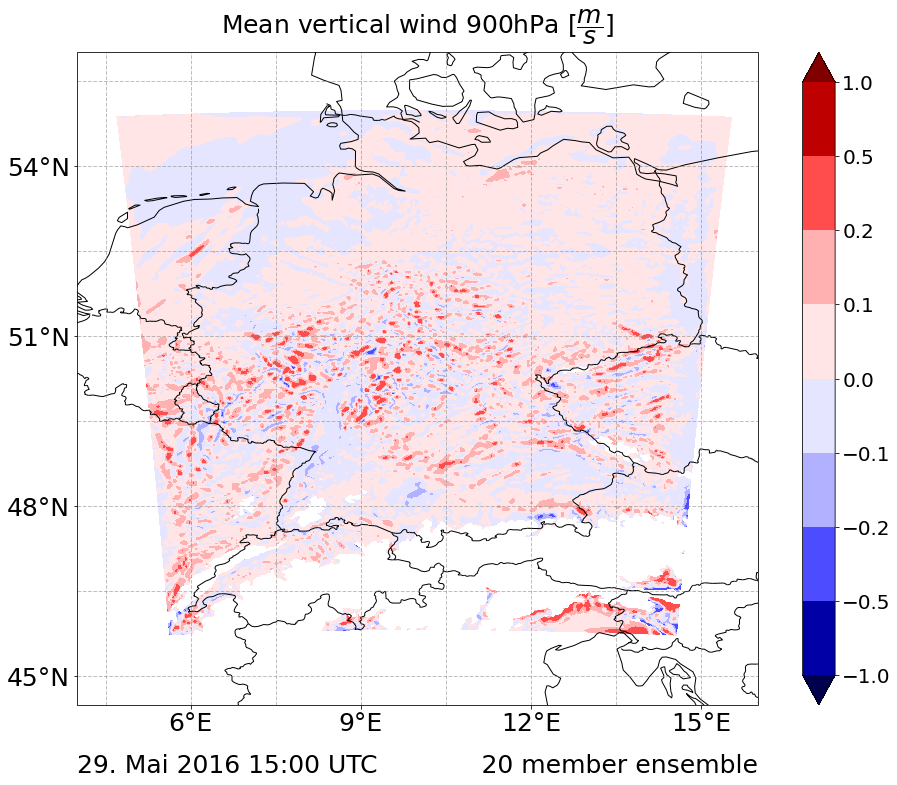

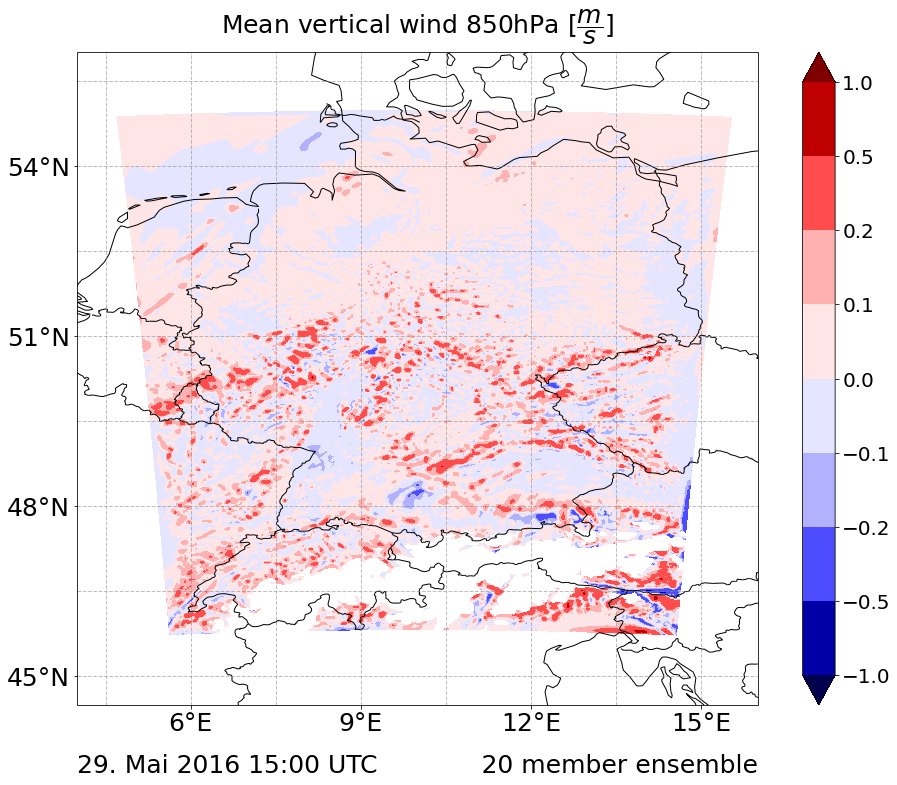

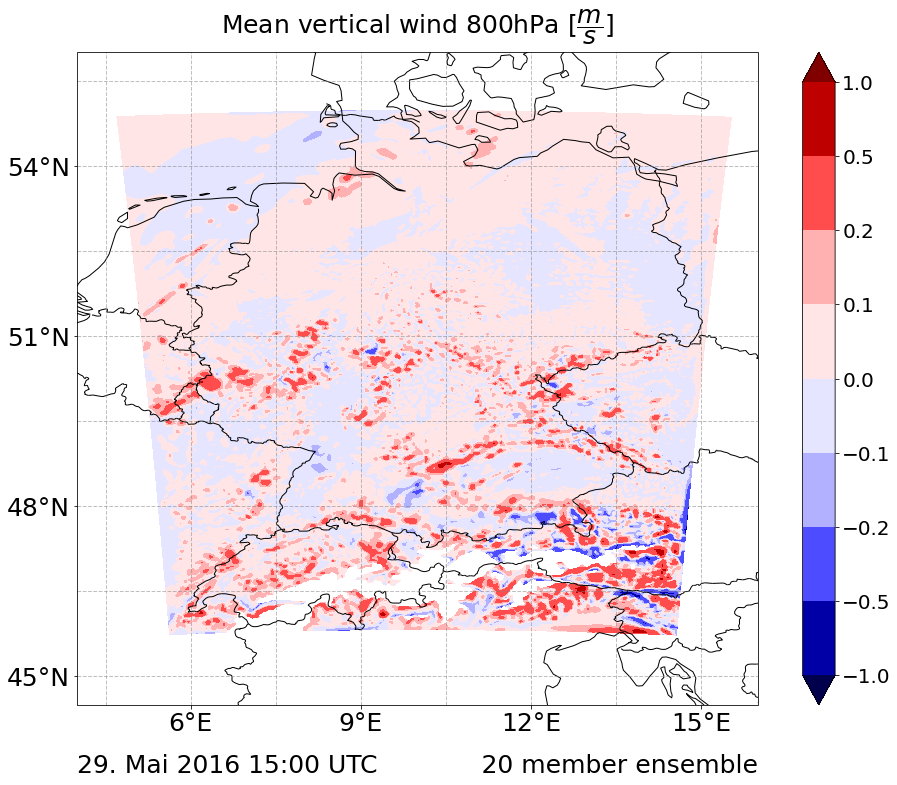

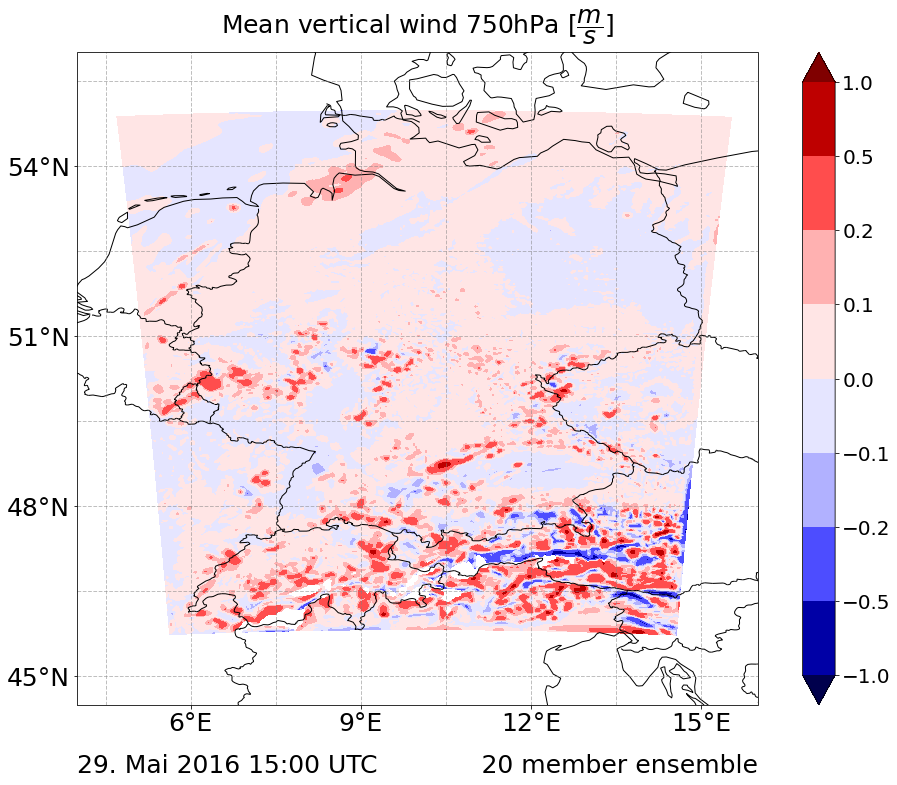

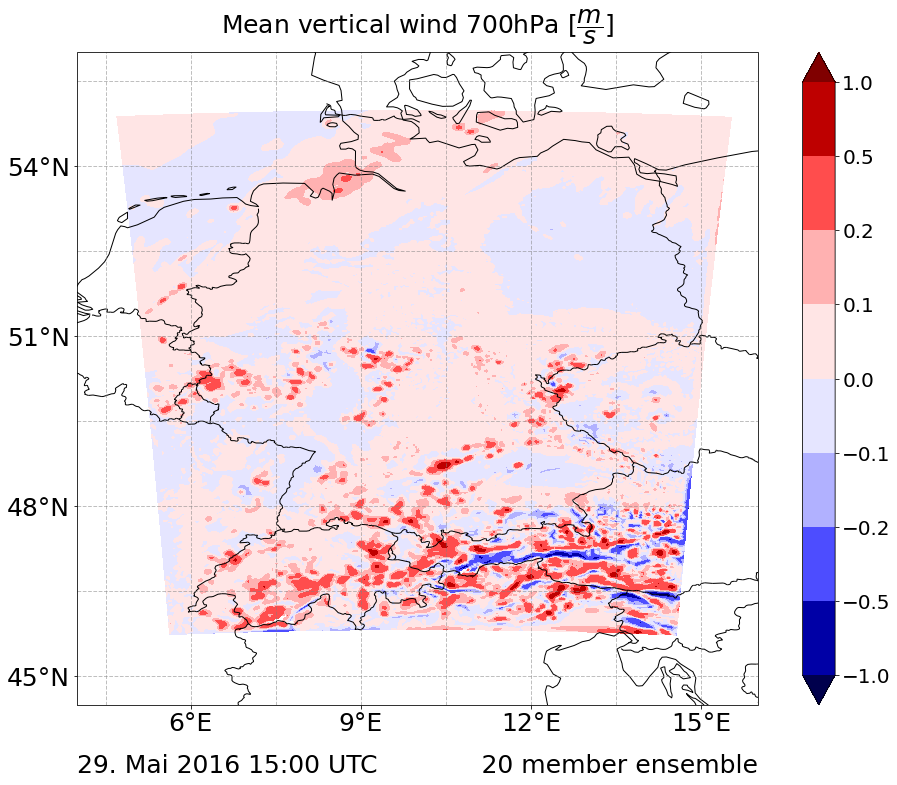

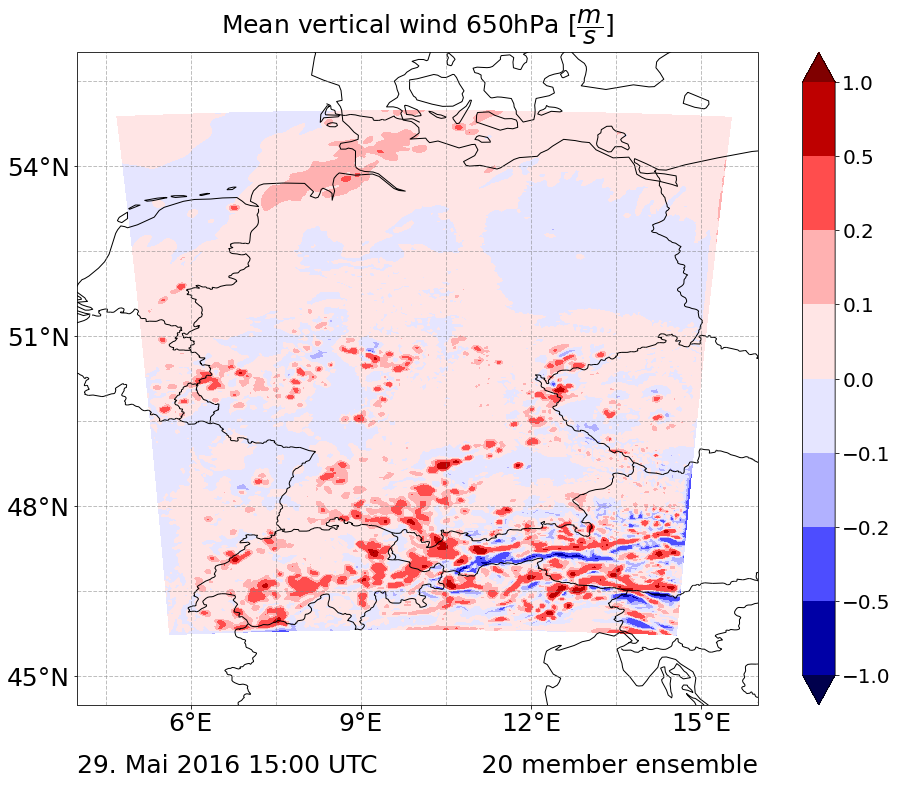

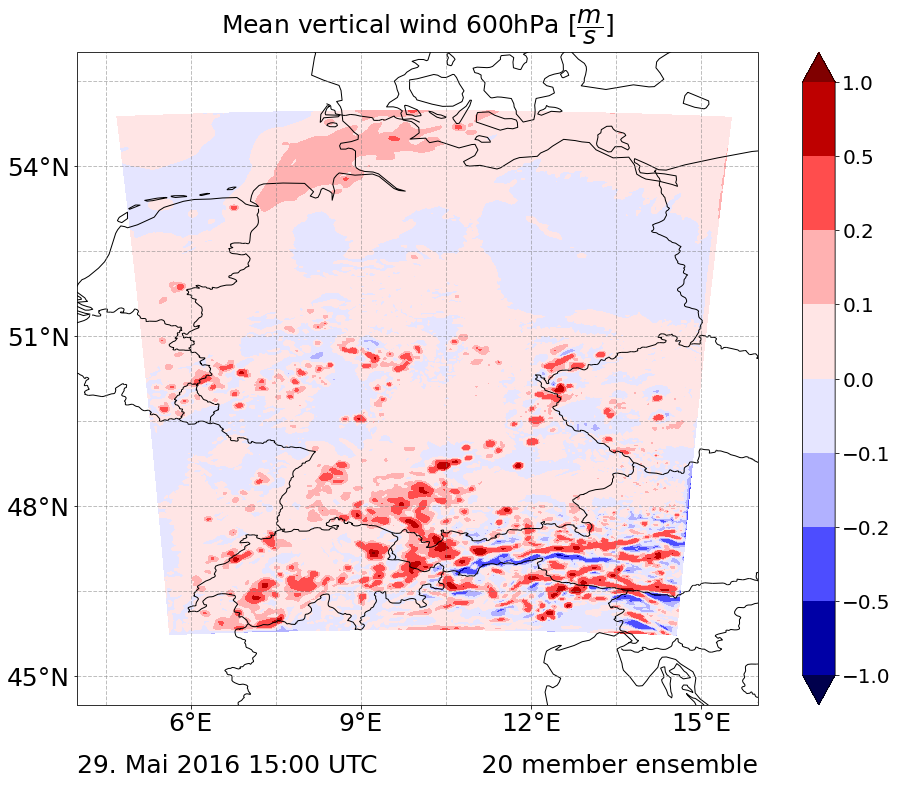

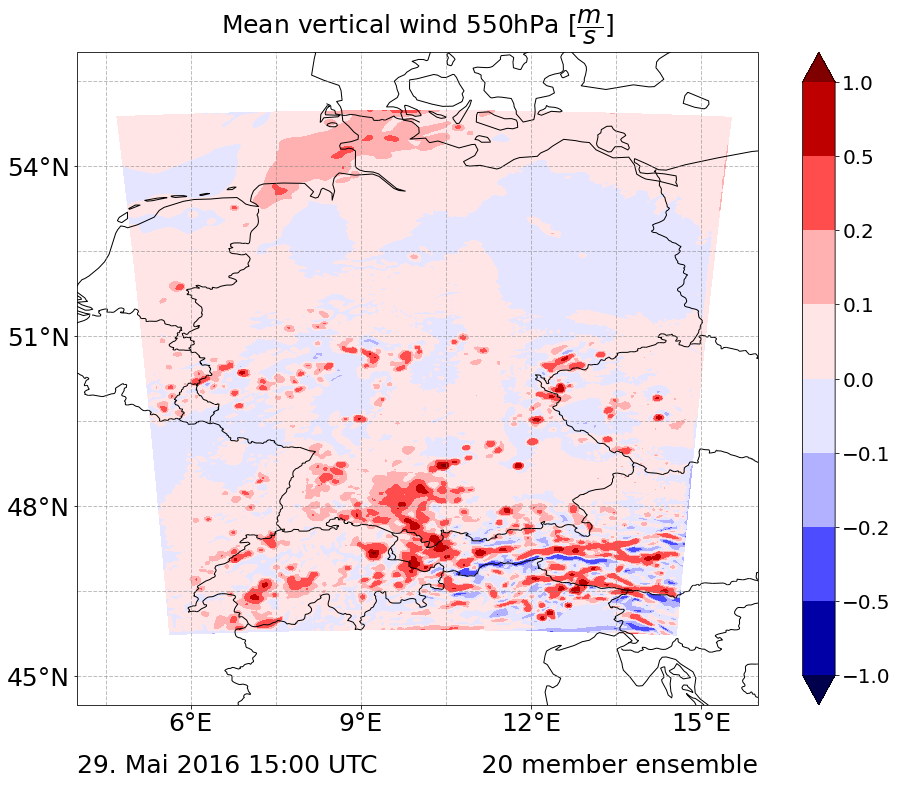

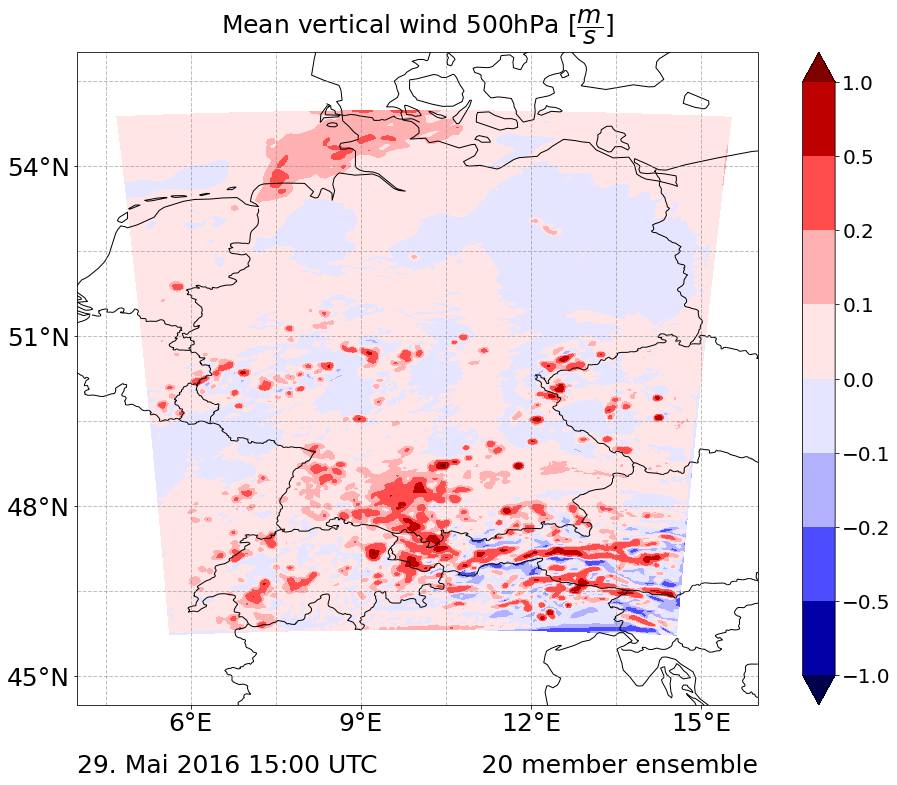

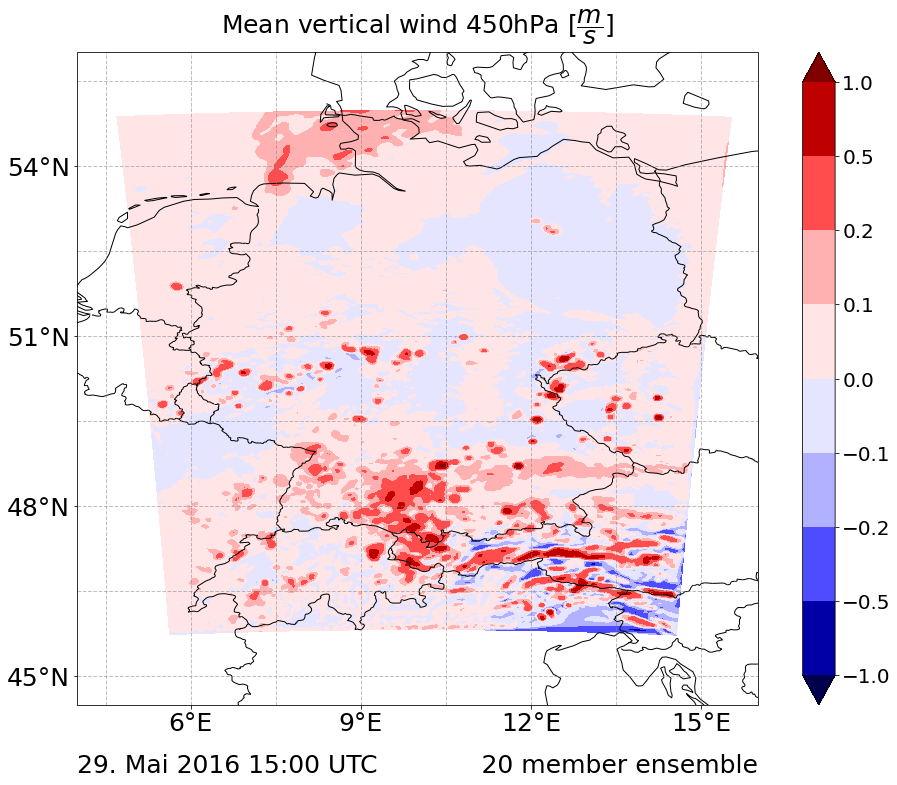

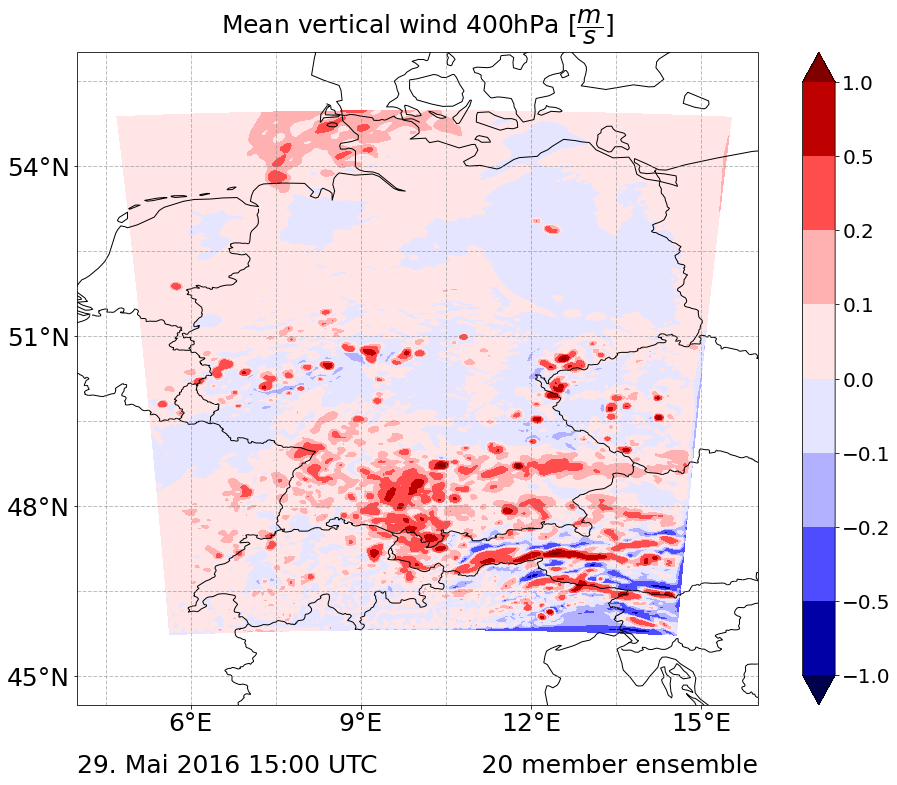

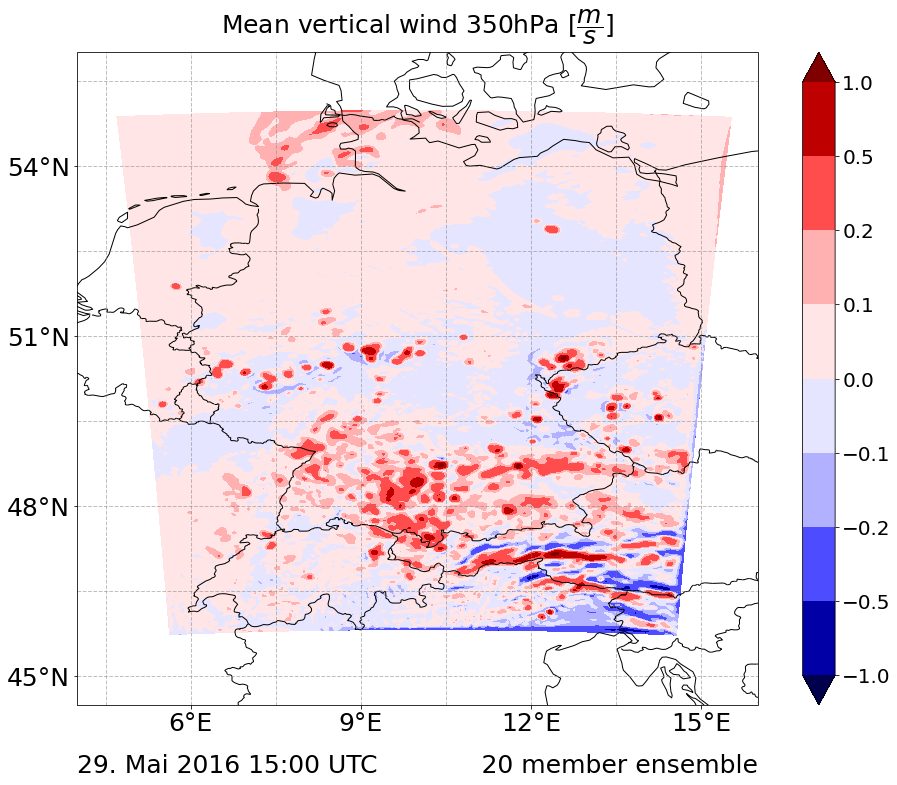

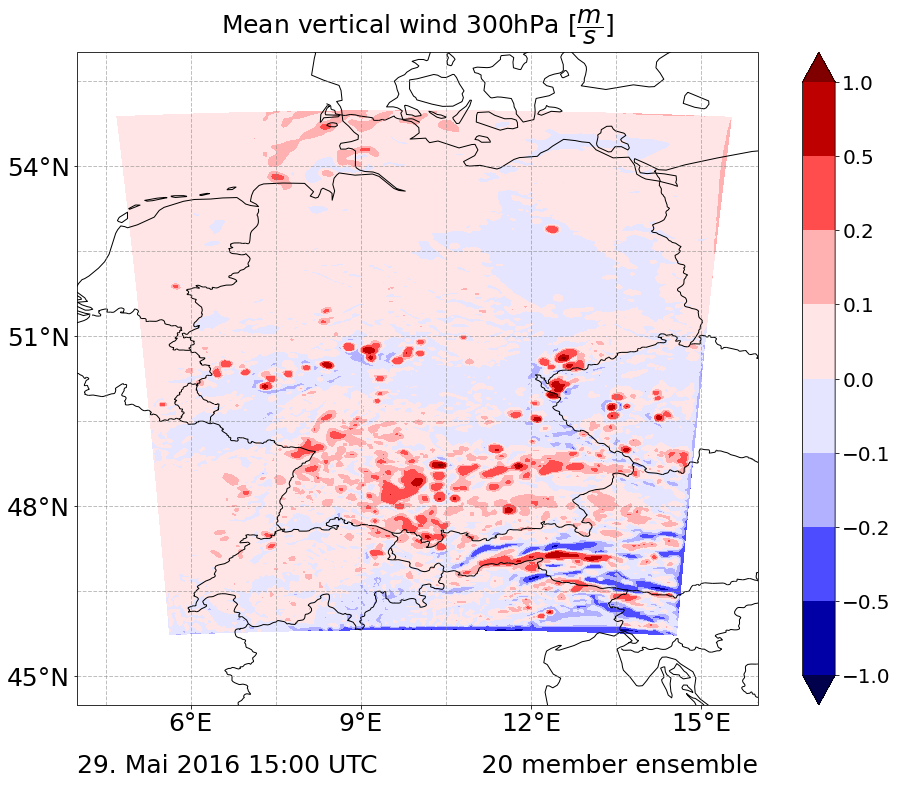

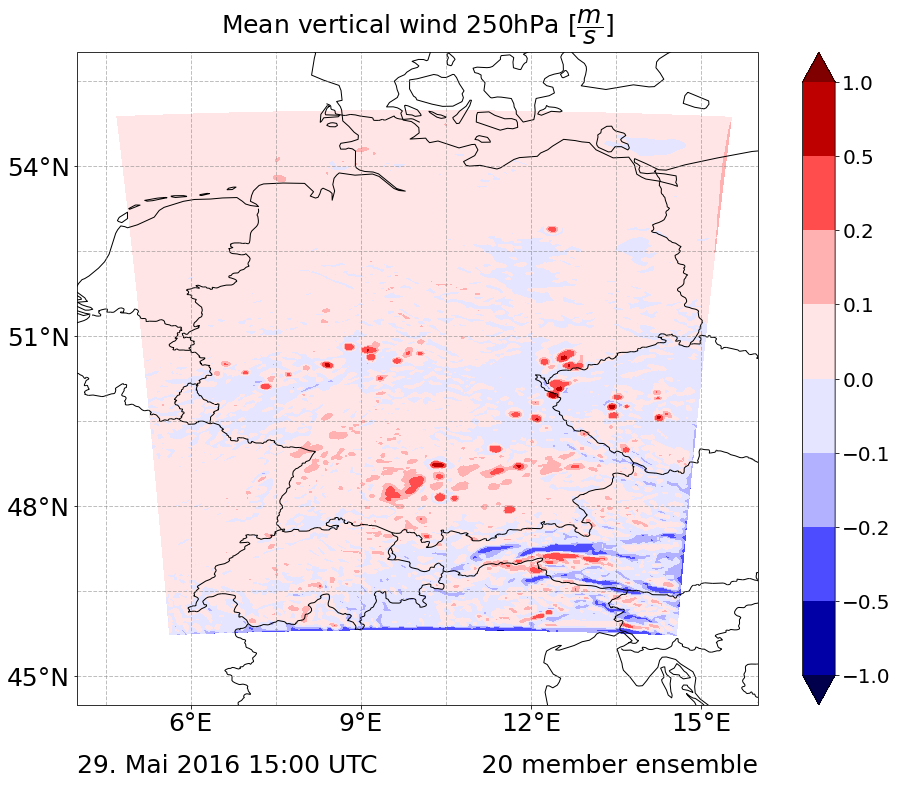

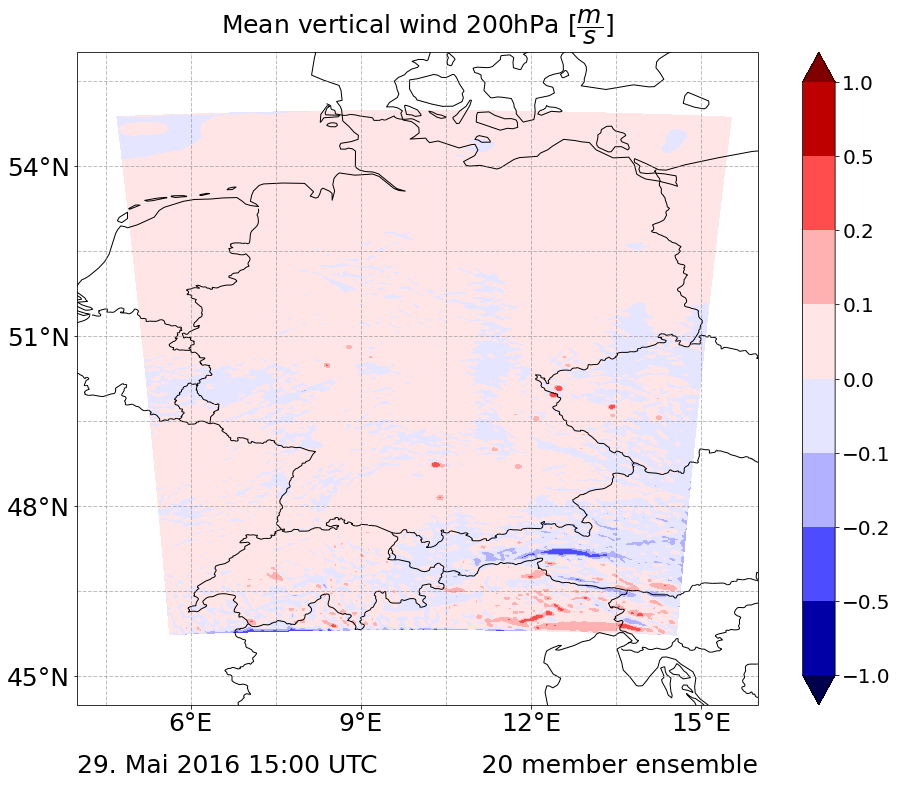

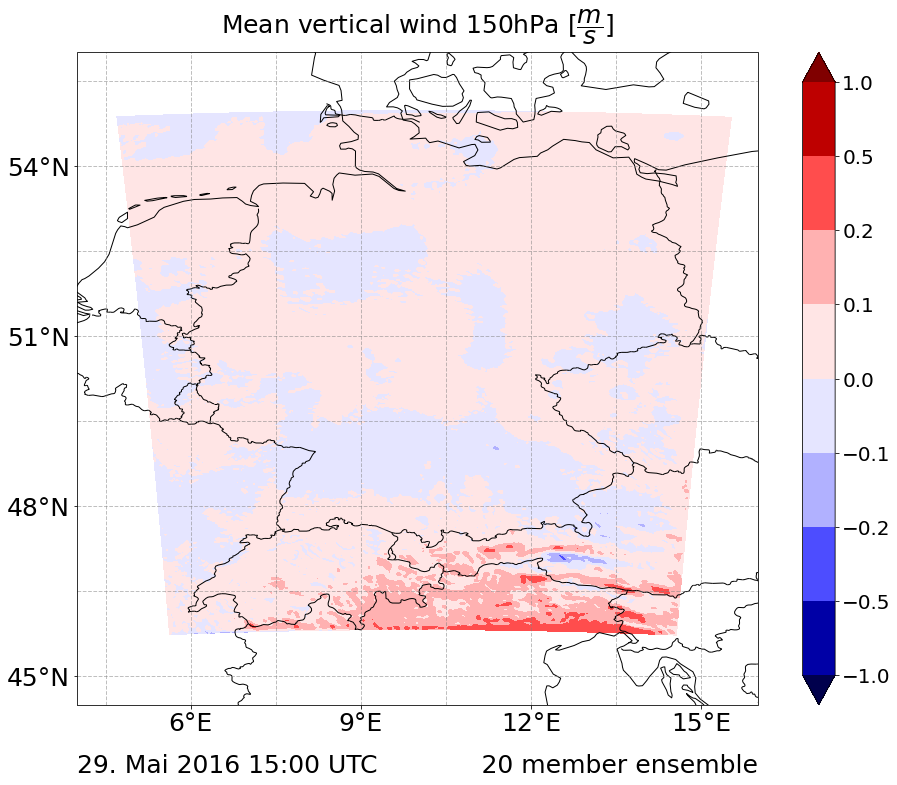

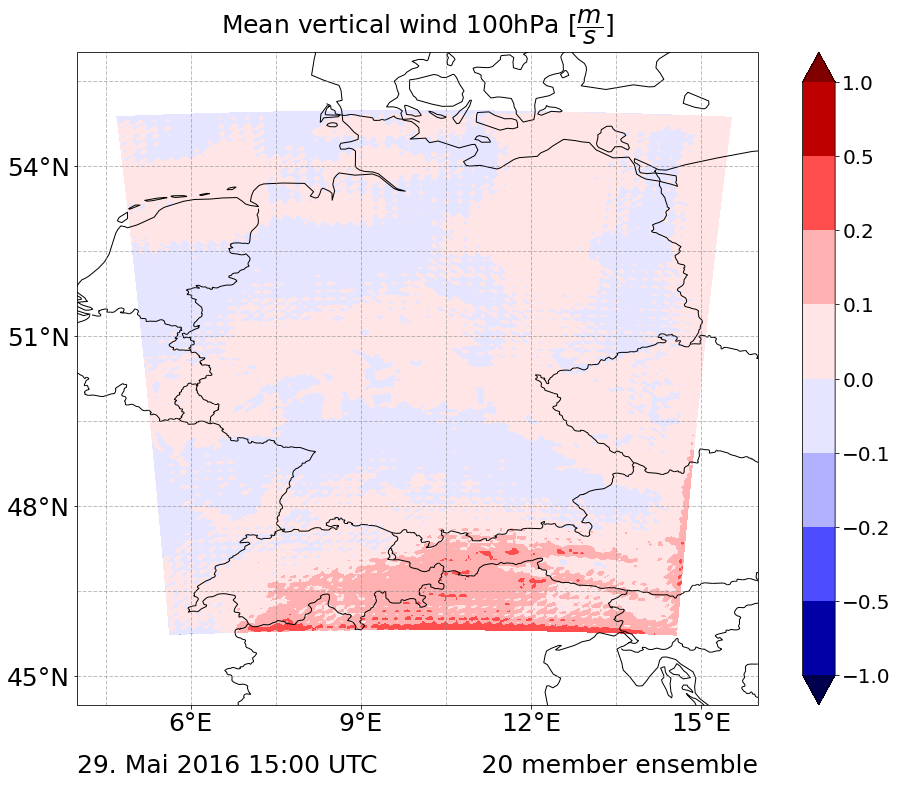

In [28]:
# change range number for all vertical levels (20)
for i in range(20):
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

    # Plot precipitaion with special colorbar
    clevs = [-1,-0.5,-0.2,-0.1,0,0.1,0.2,0.5,1]
    #colors = ("#ffffff","#F0EABB","#C0E69F","#72E1A2","#00D8BC","#00C7DC","#00AAF2","#847CF2","#BA3CD0","#B40087")
    plt.contourf(lon2d, lat2d,dataset_CL.isel(time=1,lev=i, lat = np.arange(7,345,1),lon = np.arange(12,243,1)).mean('ens')['w'],clevs,cmap='seismic', extend='both', transform=crs.PlateCarree()) 
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=20)

    # Customize fig, axis and labels
    ax.set_title('Mean vertical wind '+ str(int(dataset_CL.coords['lev'].values[i])) +'hPa $[\dfrac{m}{s}]$', size =25,y=1.02)
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
    ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
    ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
#     plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/w_'+str(int(dataset.coords['lev'].values[i]))+'_'+ens+'mem_2016'+date+'1500.png')

### Vertical Slices

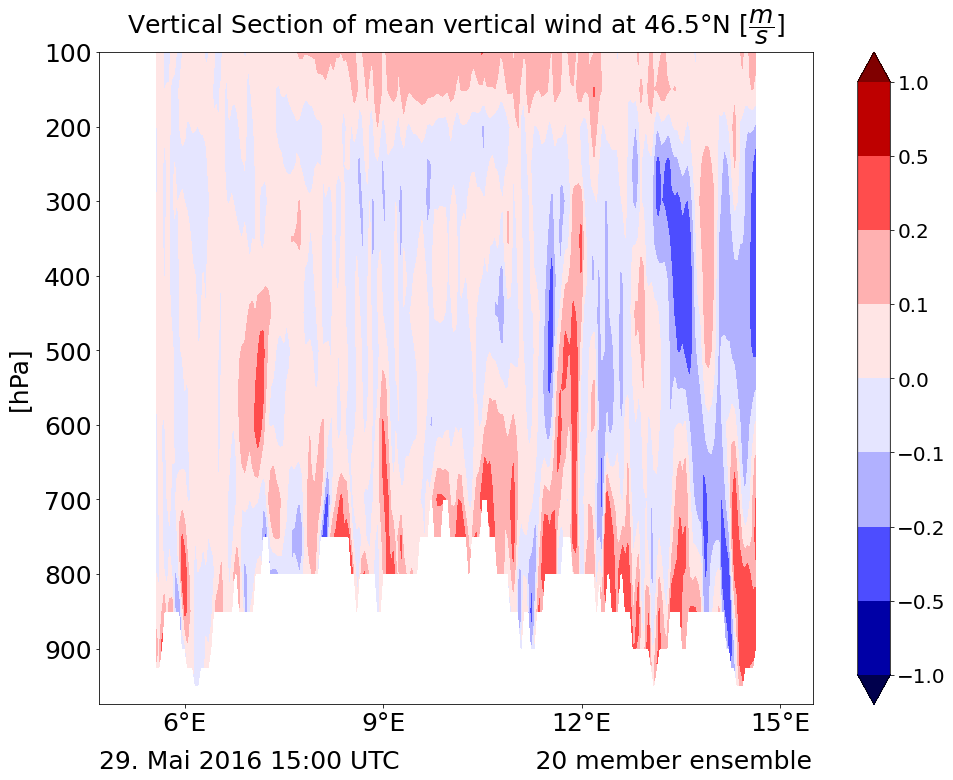

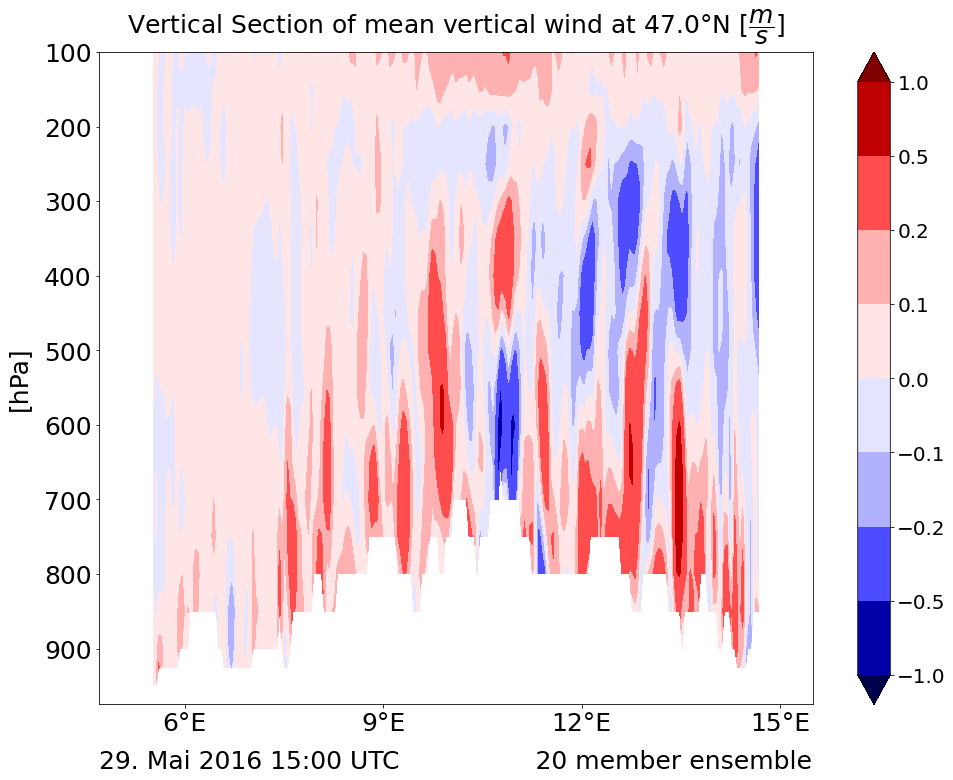

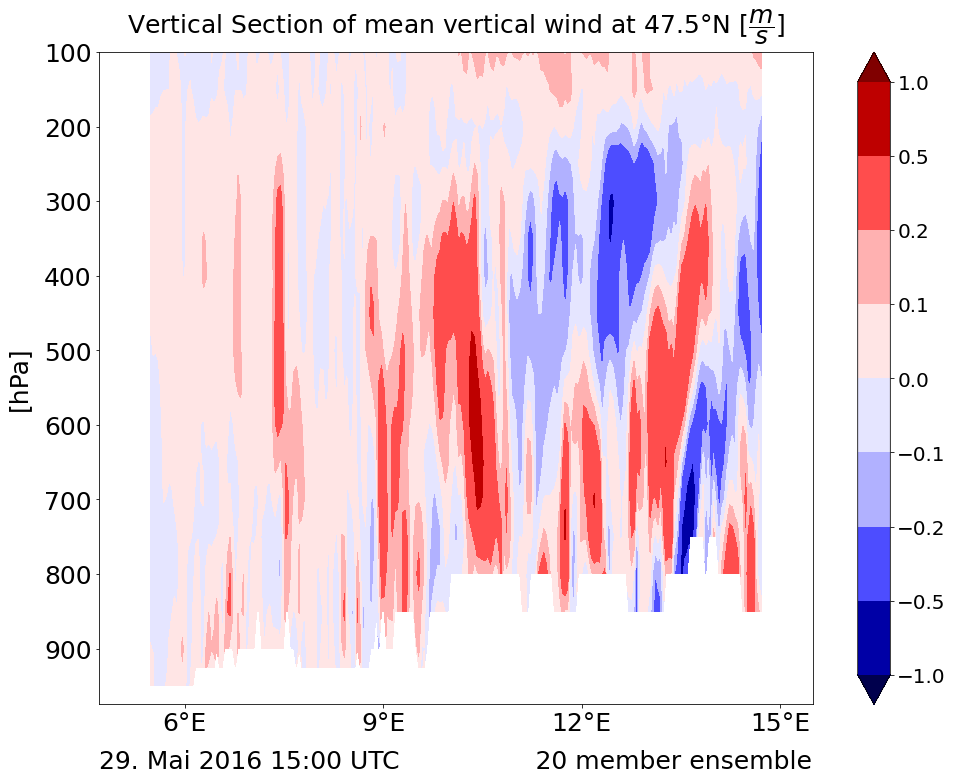

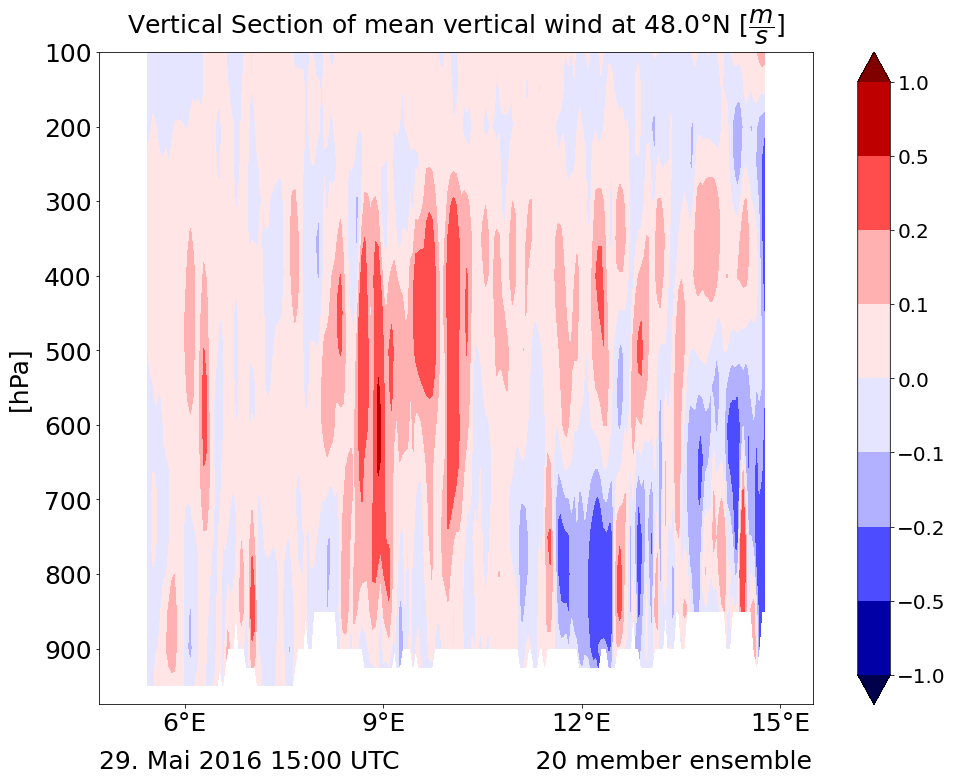

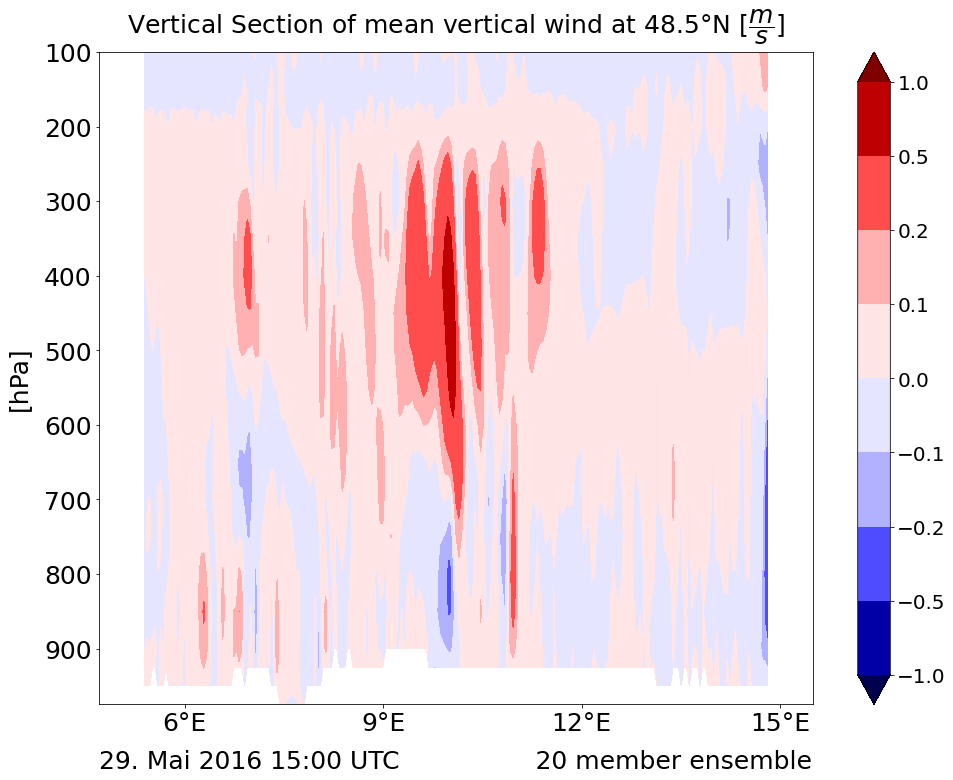

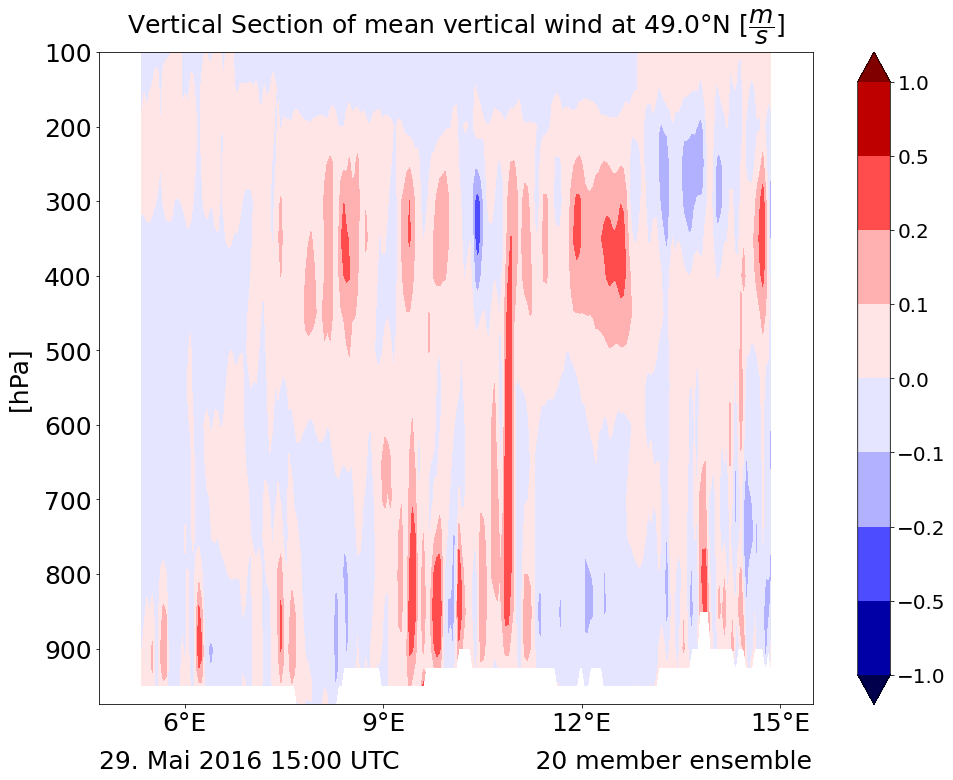

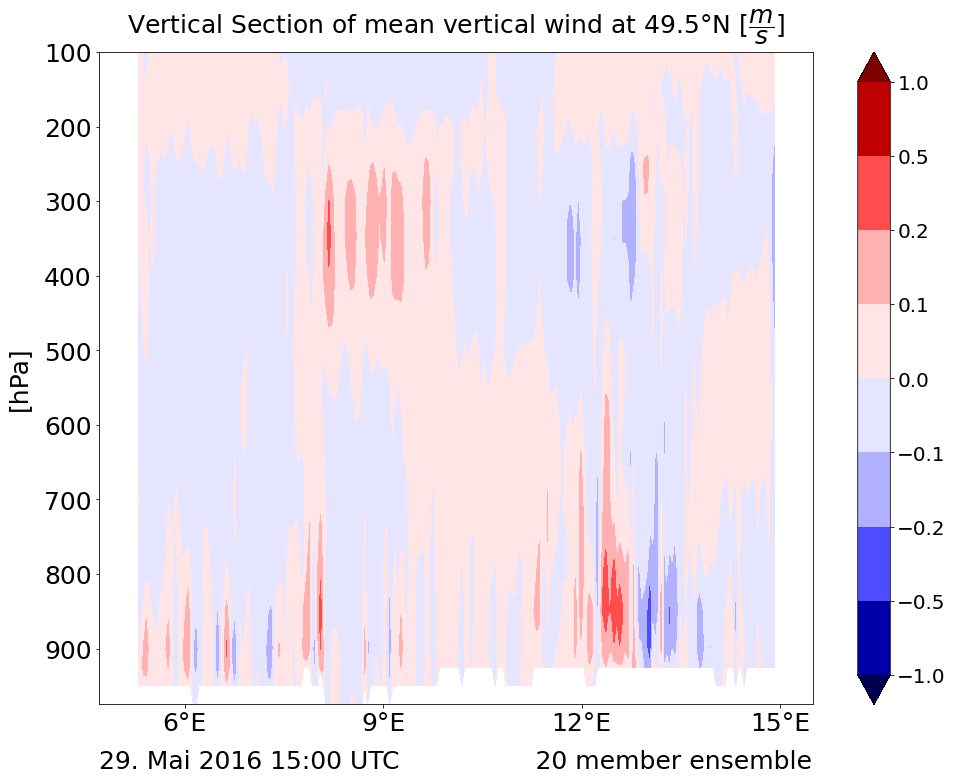

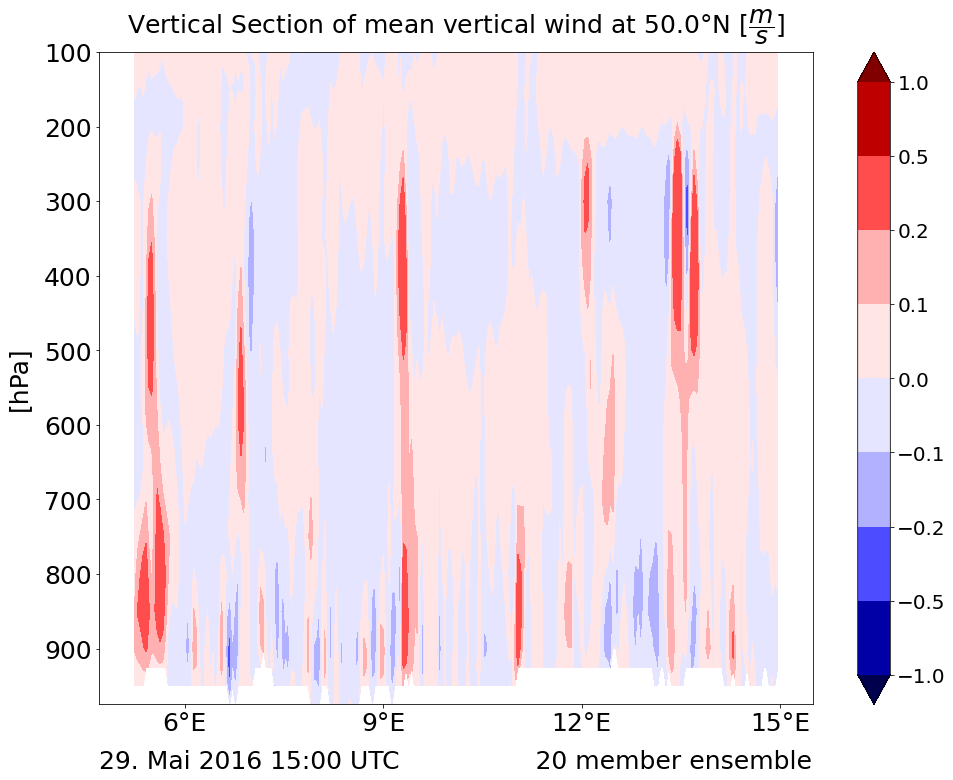

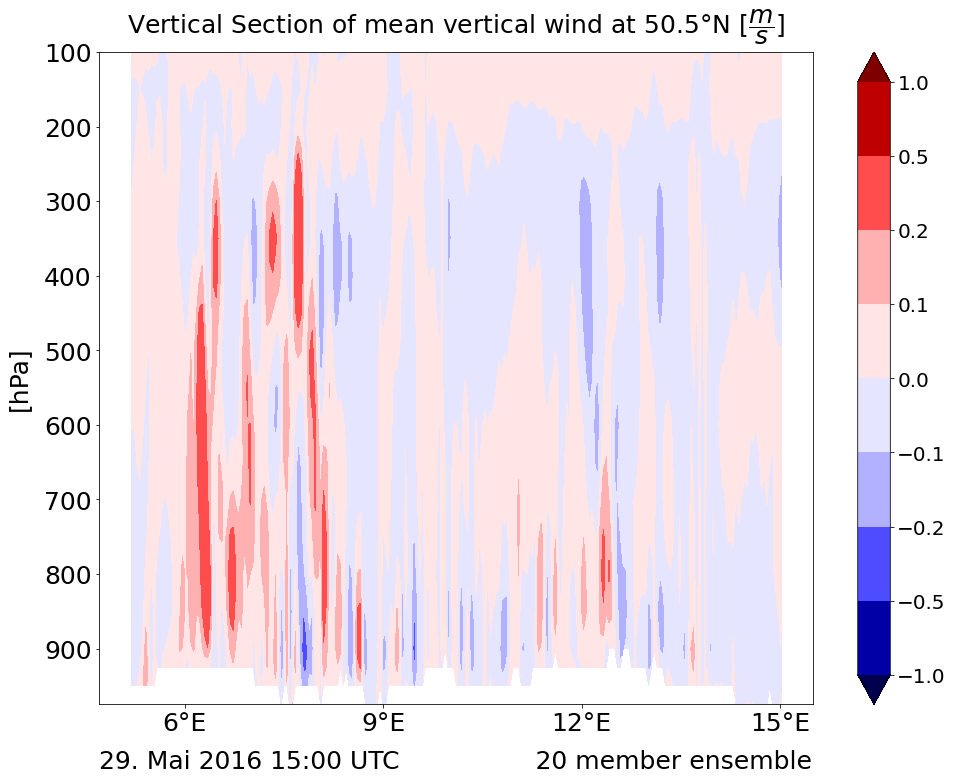

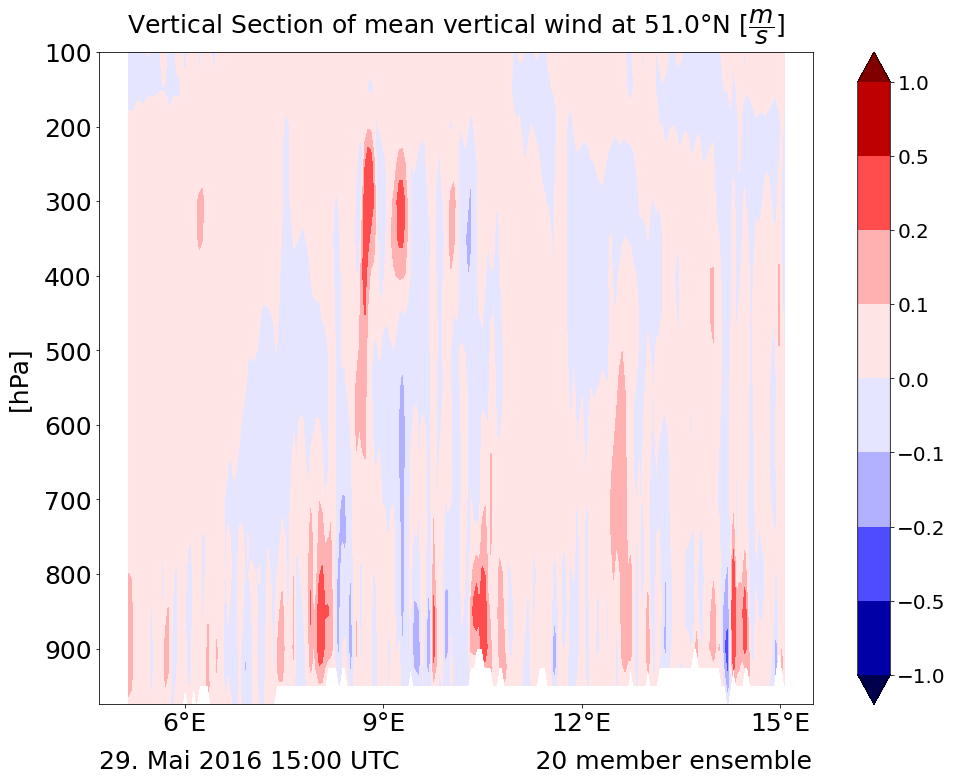

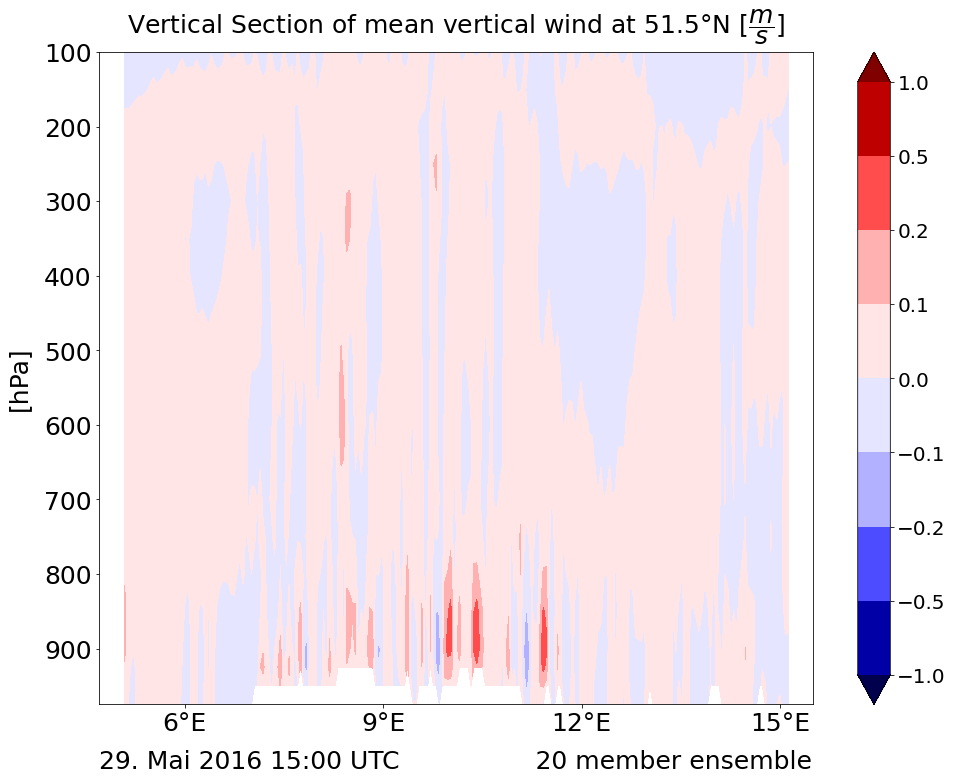

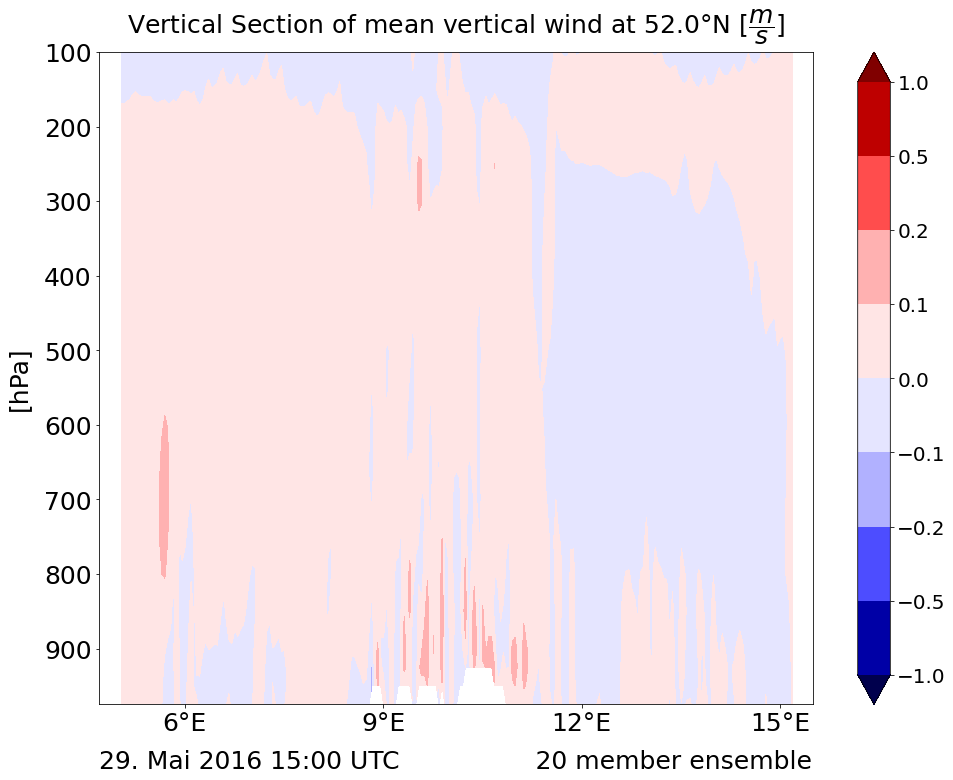

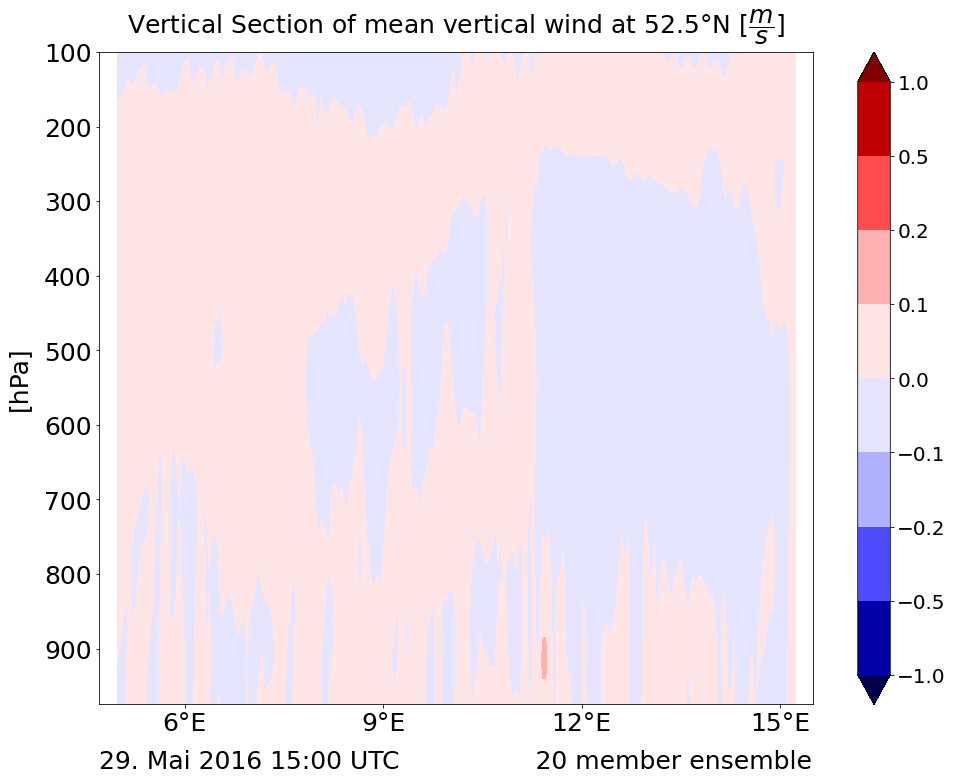

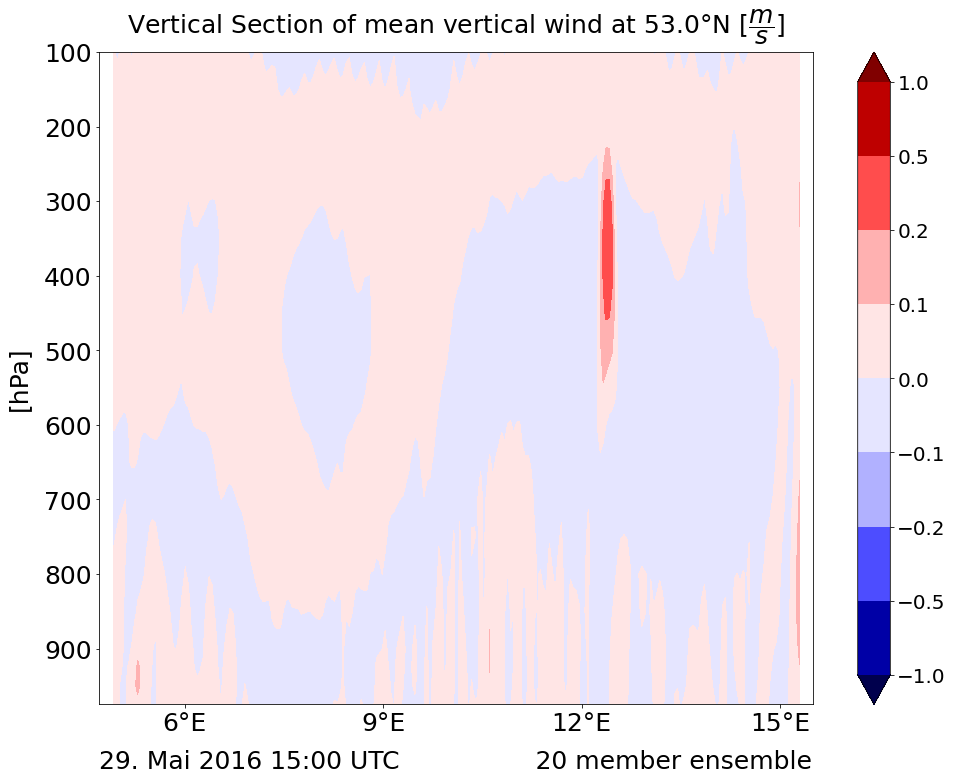

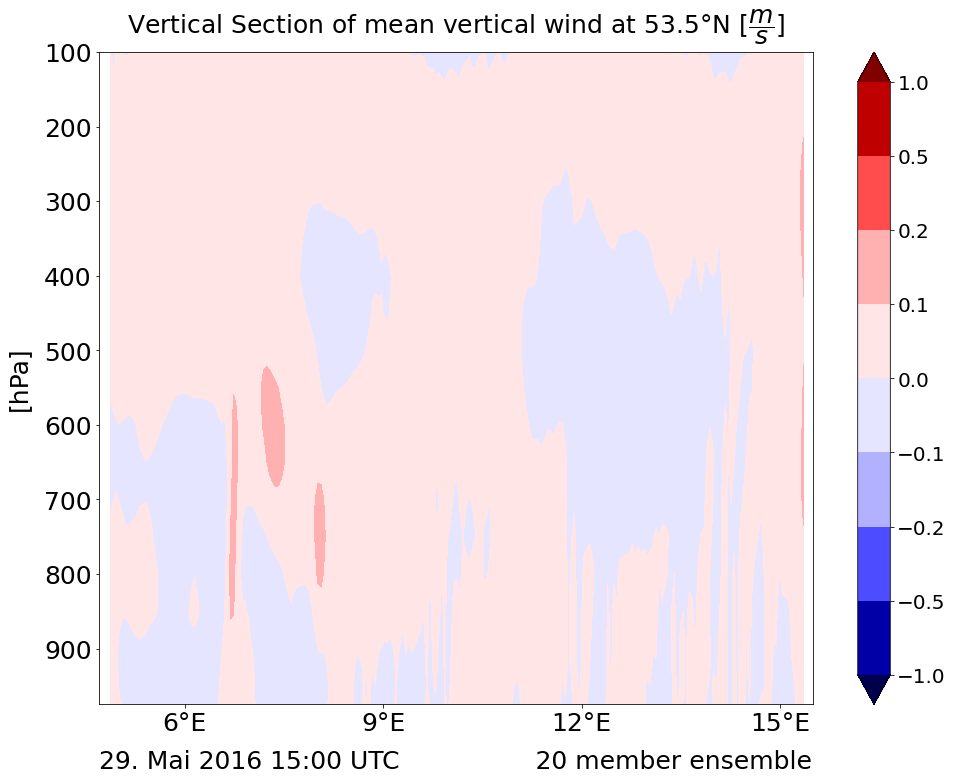

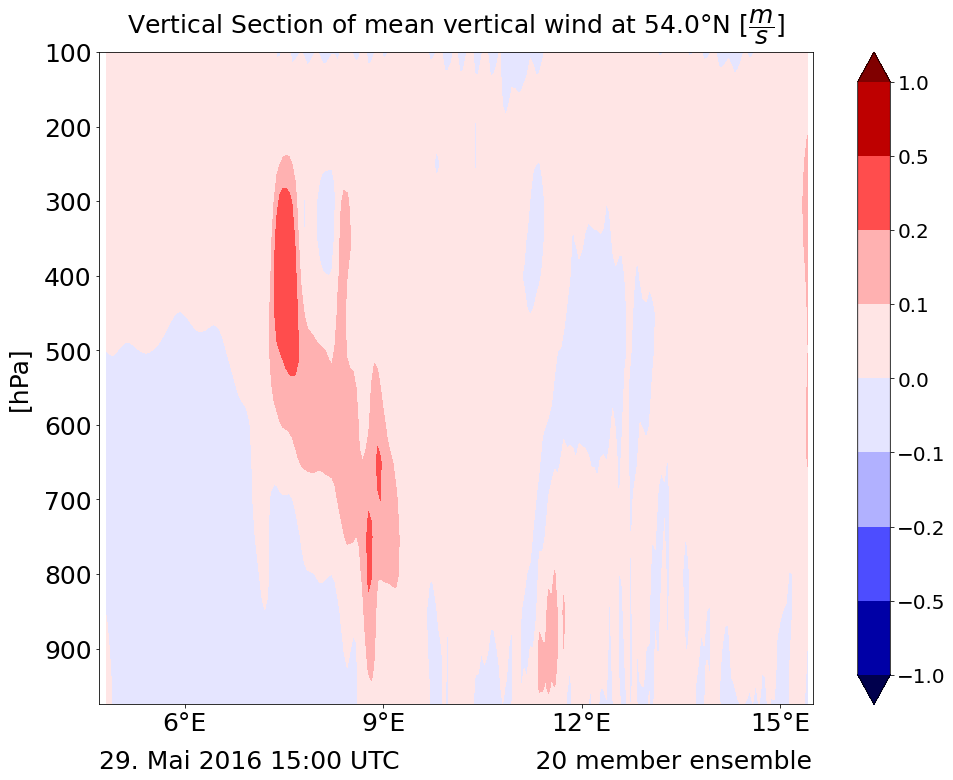

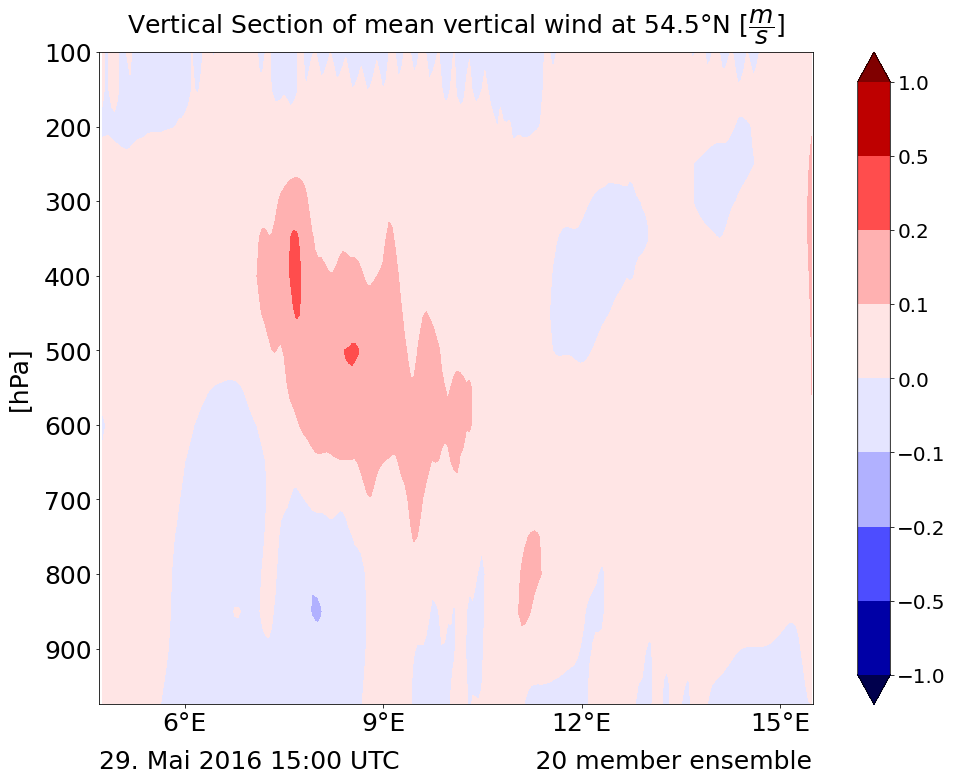

In [30]:
latslice = [26,45,63,81,100,118,137,155,173,192,210,229,247,266,284,302,321]
for i in range(len(latslice)):
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(1,1,1)

    clevs = [-1,-0.5,-0.2,-0.1,0,0.1,0.2,0.5,1]
    plt.contourf(lon2d[latslice[i]], dataset_CL.coords['lev'].values,dataset_CL.isel(time=1,lat=latslice[i],lon = np.arange(12,243,1)).mean('ens')['w'],clevs,cmap='seismic', extend='both')
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=20)

    ax.invert_yaxis()
    ax.set_title('Vertical Section of mean vertical wind at '+"%.1f" % np.mean(lat2d[latslice[i]])+'°N $[\dfrac{m}{s}]$', size =25,y=1.02)
    ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.ylabel('[hPa]',labelpad=13, fontsize = 25)
    ax.set_xlim([4.7, 15.5])
    ax.text(4.7,1060,day+'. '+m+' 2016 '+t+' UTC                 '+ens+' member ensemble', size =25)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)
#     plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/w_section_'+"%.1f" % np.mean(lat2d[latslice[i]])+'_'+ens+'mem_2016'+date+'1500.png')

## Plotting Cloud Phase

(array([0.0e+00, 5.0e-06, 1.0e-05, 1.5e-05, 2.0e-05]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

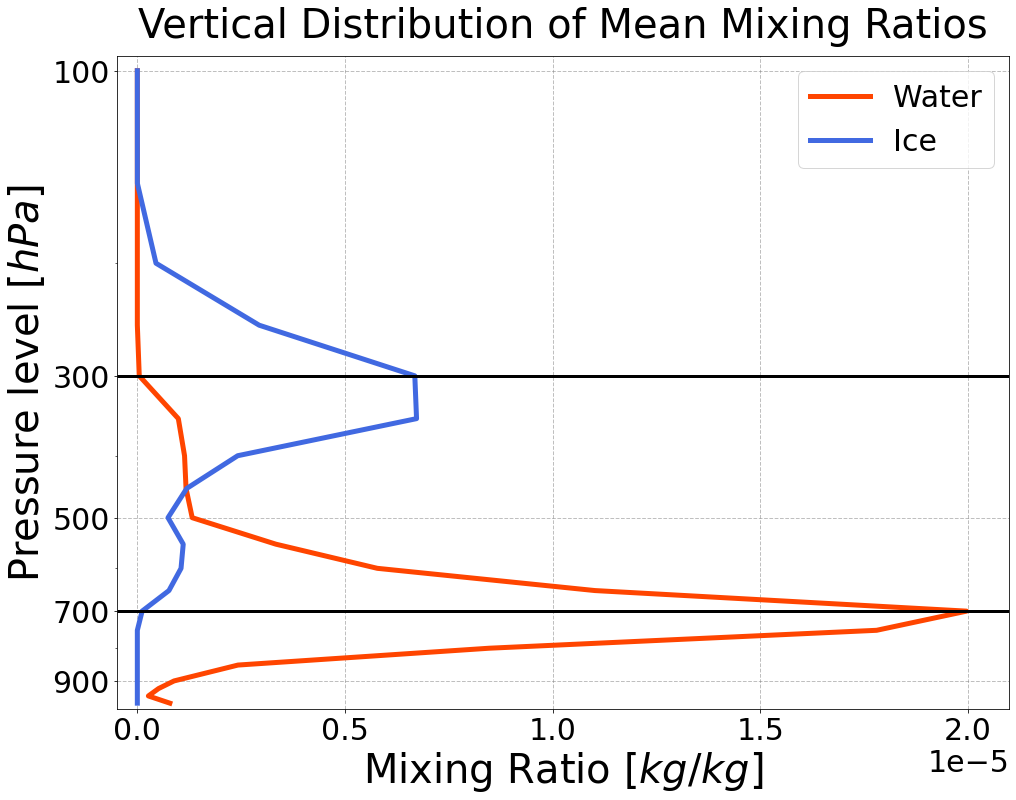

In [31]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

ax.plot(dataset_PH['qc'].isel(time=3, lat = np.arange(7,345,1),lon = np.arange(12,243,1)).mean('lat').mean('lon').mean('ens'),dataset_PH.coords['lev'], linewidth = 5, c = 'orangered', label = 'Water')
ax.plot(dataset_PH['qi'].isel(time=3, lat = np.arange(7,345,1),lon = np.arange(12,243,1)).mean('lat').mean('lon').mean('ens'),dataset_PH.coords['lev'], linewidth = 5, c = 'royalblue', label = 'Ice')

ax.set_yscale('log')
plt.legend(fontsize = 30)
ax.invert_yaxis()
ax.hlines(300,-0.05e-5,2.1e-5, linewidth = 3, color = 'k')
ax.hlines(700,-0.05e-5,2.1e-5, linewidth = 3, color = 'k')
ax.set_title('Vertical Distribution of Mean Mixing Ratios', size =40,y=1.02)
ax.set_ylabel('Pressure level [$hPa$]',size = 40)
ax.set_xlabel('Mixing Ratio [$kg/kg$]',size = 40)
ax.set_yticks(ticks=[100,300,500,700,900])
ax.set_yticklabels([100,300,500,700,900])
ax.set_xticks(np.linspace(0,2,5)*1e-5)
plt.ylim(995,95)
plt.xlim(-0.05e-5,2.1e-5)
ax.grid(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.xaxis.offsetText.set_fontsize(30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_mixing_ratio_'+ens+'mem_2016'+date+'1500.png')